# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

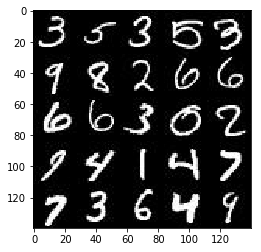

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

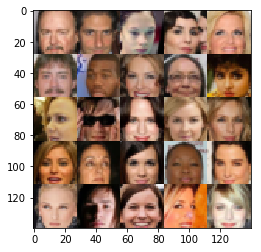

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_height, image_width,image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32,name="learning_rate")
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope('discriminator',reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse = not is_train
    alpha = 0.1
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128

        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """

    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #saver = tf.train.Saver()
    losses = []
    _,image_width,image_height,image_channels = data_shape
    input_real, input_z , _ = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss,learning_rate, beta1)
    steps = 0
    n_images = 20
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_real: batch_images, input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)

                

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2... Discriminator Loss: 4.1405... Generator Loss: 0.0236
Epoch 1/2... Discriminator Loss: 3.2912... Generator Loss: 0.0468
Epoch 1/2... Discriminator Loss: 3.2491... Generator Loss: 0.0576
Epoch 1/2... Discriminator Loss: 0.5010... Generator Loss: 1.8376
Epoch 1/2... Discriminator Loss: 0.2218... Generator Loss: 2.8362
Epoch 1/2... Discriminator Loss: 1.6584... Generator Loss: 7.8315
Epoch 1/2... Discriminator Loss: 1.4870... Generator Loss: 0.3574
Epoch 1/2... Discriminator Loss: 1.5501... Generator Loss: 0.8129
Epoch 1/2... Discriminator Loss: 0.7523... Generator Loss: 2.0181
Epoch 1/2... Discriminator Loss: 1.0027... Generator Loss: 0.5933


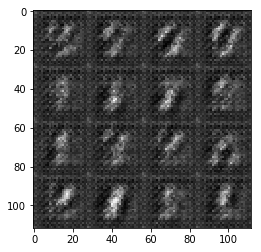

Epoch 1/2... Discriminator Loss: 1.8306... Generator Loss: 0.2827
Epoch 1/2... Discriminator Loss: 1.1922... Generator Loss: 0.6582
Epoch 1/2... Discriminator Loss: 1.9662... Generator Loss: 0.2172
Epoch 1/2... Discriminator Loss: 1.6523... Generator Loss: 0.3030
Epoch 1/2... Discriminator Loss: 2.0579... Generator Loss: 0.1766
Epoch 1/2... Discriminator Loss: 1.4252... Generator Loss: 0.3999
Epoch 1/2... Discriminator Loss: 1.4720... Generator Loss: 0.3288
Epoch 1/2... Discriminator Loss: 1.4703... Generator Loss: 0.3536
Epoch 1/2... Discriminator Loss: 1.4313... Generator Loss: 0.3722
Epoch 1/2... Discriminator Loss: 1.2222... Generator Loss: 0.5137


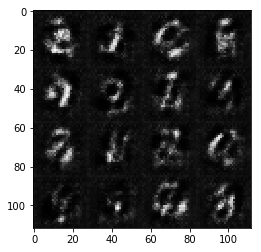

Epoch 1/2... Discriminator Loss: 1.1885... Generator Loss: 0.5226
Epoch 1/2... Discriminator Loss: 1.1504... Generator Loss: 0.5755
Epoch 1/2... Discriminator Loss: 1.0867... Generator Loss: 1.2582
Epoch 1/2... Discriminator Loss: 1.2706... Generator Loss: 1.5405
Epoch 1/2... Discriminator Loss: 1.1147... Generator Loss: 0.9159
Epoch 1/2... Discriminator Loss: 1.1817... Generator Loss: 1.3892
Epoch 1/2... Discriminator Loss: 0.9704... Generator Loss: 0.9999
Epoch 1/2... Discriminator Loss: 0.9588... Generator Loss: 0.8352
Epoch 1/2... Discriminator Loss: 1.1735... Generator Loss: 0.4929
Epoch 1/2... Discriminator Loss: 0.9723... Generator Loss: 0.8836


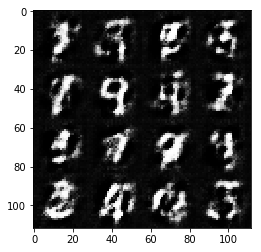

Epoch 1/2... Discriminator Loss: 1.4125... Generator Loss: 0.3943
Epoch 1/2... Discriminator Loss: 0.8212... Generator Loss: 1.1417
Epoch 1/2... Discriminator Loss: 0.8619... Generator Loss: 1.1297
Epoch 1/2... Discriminator Loss: 1.1462... Generator Loss: 0.4955
Epoch 1/2... Discriminator Loss: 1.0523... Generator Loss: 0.6219
Epoch 1/2... Discriminator Loss: 1.0620... Generator Loss: 0.5816
Epoch 1/2... Discriminator Loss: 0.9124... Generator Loss: 0.9265
Epoch 1/2... Discriminator Loss: 0.9116... Generator Loss: 1.0457
Epoch 1/2... Discriminator Loss: 0.9971... Generator Loss: 1.6784
Epoch 1/2... Discriminator Loss: 1.3522... Generator Loss: 0.3914


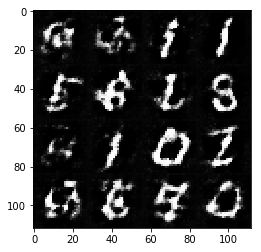

Epoch 1/2... Discriminator Loss: 1.2697... Generator Loss: 1.4227
Epoch 1/2... Discriminator Loss: 0.9827... Generator Loss: 0.9020
Epoch 1/2... Discriminator Loss: 1.1887... Generator Loss: 0.5222
Epoch 1/2... Discriminator Loss: 1.2819... Generator Loss: 0.4090
Epoch 1/2... Discriminator Loss: 1.2498... Generator Loss: 1.6521
Epoch 1/2... Discriminator Loss: 0.9622... Generator Loss: 1.2218
Epoch 1/2... Discriminator Loss: 0.9304... Generator Loss: 0.8471
Epoch 1/2... Discriminator Loss: 1.3151... Generator Loss: 0.4071
Epoch 1/2... Discriminator Loss: 1.1079... Generator Loss: 1.2835
Epoch 1/2... Discriminator Loss: 1.0043... Generator Loss: 1.6226


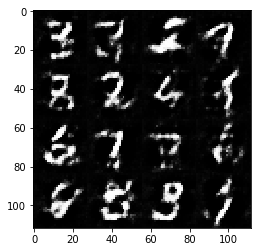

Epoch 1/2... Discriminator Loss: 1.2249... Generator Loss: 0.4734
Epoch 1/2... Discriminator Loss: 1.0646... Generator Loss: 1.9693
Epoch 1/2... Discriminator Loss: 1.0924... Generator Loss: 1.4315
Epoch 1/2... Discriminator Loss: 0.9532... Generator Loss: 0.7600
Epoch 1/2... Discriminator Loss: 1.2131... Generator Loss: 0.4902
Epoch 1/2... Discriminator Loss: 1.1842... Generator Loss: 1.8068
Epoch 1/2... Discriminator Loss: 1.3072... Generator Loss: 0.4830
Epoch 1/2... Discriminator Loss: 0.9788... Generator Loss: 0.8153
Epoch 1/2... Discriminator Loss: 1.4211... Generator Loss: 0.3730
Epoch 1/2... Discriminator Loss: 1.4874... Generator Loss: 0.3688


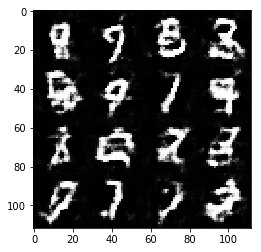

Epoch 1/2... Discriminator Loss: 0.9356... Generator Loss: 1.3109
Epoch 1/2... Discriminator Loss: 1.6871... Generator Loss: 0.2658
Epoch 1/2... Discriminator Loss: 1.4989... Generator Loss: 0.3349
Epoch 1/2... Discriminator Loss: 1.1462... Generator Loss: 0.5941
Epoch 1/2... Discriminator Loss: 0.8951... Generator Loss: 1.1002
Epoch 1/2... Discriminator Loss: 1.0558... Generator Loss: 0.7076
Epoch 1/2... Discriminator Loss: 1.6089... Generator Loss: 0.2866
Epoch 1/2... Discriminator Loss: 1.2123... Generator Loss: 0.9849
Epoch 1/2... Discriminator Loss: 1.0511... Generator Loss: 1.2001
Epoch 1/2... Discriminator Loss: 1.0266... Generator Loss: 0.6969


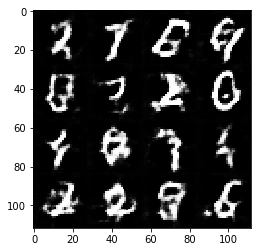

Epoch 1/2... Discriminator Loss: 0.9219... Generator Loss: 1.6011
Epoch 1/2... Discriminator Loss: 0.9269... Generator Loss: 1.3097
Epoch 1/2... Discriminator Loss: 1.1491... Generator Loss: 0.5199
Epoch 1/2... Discriminator Loss: 1.2876... Generator Loss: 1.5543
Epoch 1/2... Discriminator Loss: 0.9575... Generator Loss: 1.3531
Epoch 1/2... Discriminator Loss: 1.4547... Generator Loss: 0.3447
Epoch 1/2... Discriminator Loss: 0.9855... Generator Loss: 0.7543
Epoch 1/2... Discriminator Loss: 1.3626... Generator Loss: 0.4407
Epoch 1/2... Discriminator Loss: 1.3603... Generator Loss: 0.3770
Epoch 1/2... Discriminator Loss: 0.9237... Generator Loss: 1.7581


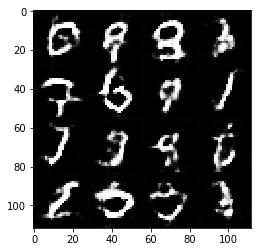

Epoch 1/2... Discriminator Loss: 0.9180... Generator Loss: 0.8215
Epoch 1/2... Discriminator Loss: 1.2140... Generator Loss: 0.4610
Epoch 1/2... Discriminator Loss: 1.0226... Generator Loss: 0.6382
Epoch 1/2... Discriminator Loss: 1.1976... Generator Loss: 0.5333
Epoch 1/2... Discriminator Loss: 1.0848... Generator Loss: 1.0949
Epoch 1/2... Discriminator Loss: 1.1080... Generator Loss: 0.5784
Epoch 1/2... Discriminator Loss: 2.6112... Generator Loss: 0.1001
Epoch 1/2... Discriminator Loss: 0.9289... Generator Loss: 0.9370
Epoch 1/2... Discriminator Loss: 1.0453... Generator Loss: 0.6451
Epoch 1/2... Discriminator Loss: 1.2218... Generator Loss: 0.4482


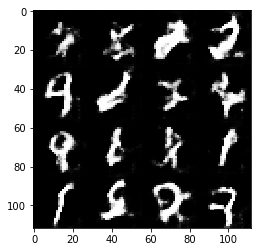

Epoch 1/2... Discriminator Loss: 0.9493... Generator Loss: 0.7937
Epoch 1/2... Discriminator Loss: 0.9021... Generator Loss: 1.4691
Epoch 1/2... Discriminator Loss: 1.7453... Generator Loss: 2.4360
Epoch 1/2... Discriminator Loss: 0.8609... Generator Loss: 0.9861
Epoch 1/2... Discriminator Loss: 2.2252... Generator Loss: 0.1485
Epoch 1/2... Discriminator Loss: 1.1839... Generator Loss: 0.5230
Epoch 1/2... Discriminator Loss: 0.8383... Generator Loss: 1.5251
Epoch 1/2... Discriminator Loss: 1.0183... Generator Loss: 0.6223
Epoch 1/2... Discriminator Loss: 1.4023... Generator Loss: 0.3662
Epoch 1/2... Discriminator Loss: 1.9718... Generator Loss: 0.1789


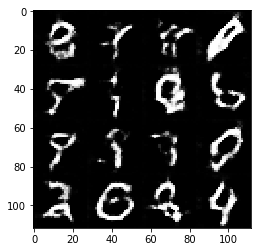

Epoch 1/2... Discriminator Loss: 1.0697... Generator Loss: 0.6848
Epoch 1/2... Discriminator Loss: 0.8869... Generator Loss: 0.8480
Epoch 1/2... Discriminator Loss: 0.8951... Generator Loss: 1.1242
Epoch 1/2... Discriminator Loss: 0.9020... Generator Loss: 1.0015
Epoch 1/2... Discriminator Loss: 0.9296... Generator Loss: 1.2380
Epoch 1/2... Discriminator Loss: 1.2972... Generator Loss: 0.4497
Epoch 1/2... Discriminator Loss: 0.8756... Generator Loss: 1.1684
Epoch 1/2... Discriminator Loss: 1.1898... Generator Loss: 0.4674
Epoch 1/2... Discriminator Loss: 0.8287... Generator Loss: 1.1037
Epoch 1/2... Discriminator Loss: 1.1319... Generator Loss: 0.6037


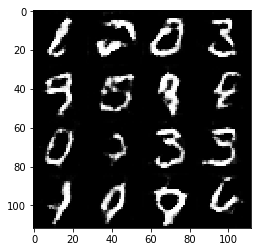

Epoch 1/2... Discriminator Loss: 0.8985... Generator Loss: 1.0330
Epoch 1/2... Discriminator Loss: 1.3914... Generator Loss: 0.3943
Epoch 1/2... Discriminator Loss: 0.7320... Generator Loss: 1.1194
Epoch 1/2... Discriminator Loss: 0.8806... Generator Loss: 0.7424
Epoch 1/2... Discriminator Loss: 1.5623... Generator Loss: 0.2964
Epoch 1/2... Discriminator Loss: 1.1166... Generator Loss: 0.5479
Epoch 1/2... Discriminator Loss: 0.7795... Generator Loss: 0.9068
Epoch 1/2... Discriminator Loss: 1.3595... Generator Loss: 0.3661
Epoch 1/2... Discriminator Loss: 1.0342... Generator Loss: 0.6135
Epoch 1/2... Discriminator Loss: 1.6837... Generator Loss: 0.3160


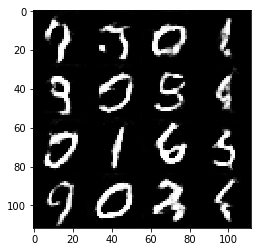

Epoch 1/2... Discriminator Loss: 0.8679... Generator Loss: 1.8009
Epoch 1/2... Discriminator Loss: 0.9346... Generator Loss: 1.2262
Epoch 1/2... Discriminator Loss: 0.8162... Generator Loss: 0.9537
Epoch 1/2... Discriminator Loss: 0.9553... Generator Loss: 0.6654
Epoch 1/2... Discriminator Loss: 2.4316... Generator Loss: 0.1260
Epoch 1/2... Discriminator Loss: 0.9123... Generator Loss: 0.8354
Epoch 1/2... Discriminator Loss: 0.8459... Generator Loss: 0.7990
Epoch 1/2... Discriminator Loss: 0.8788... Generator Loss: 0.8485
Epoch 1/2... Discriminator Loss: 1.6567... Generator Loss: 1.9349
Epoch 1/2... Discriminator Loss: 0.8177... Generator Loss: 1.0022


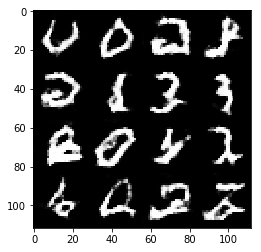

Epoch 1/2... Discriminator Loss: 1.3207... Generator Loss: 0.4562
Epoch 1/2... Discriminator Loss: 0.7474... Generator Loss: 1.2952
Epoch 1/2... Discriminator Loss: 0.7102... Generator Loss: 0.9554
Epoch 1/2... Discriminator Loss: 1.2224... Generator Loss: 2.2368
Epoch 1/2... Discriminator Loss: 1.0796... Generator Loss: 0.5618
Epoch 1/2... Discriminator Loss: 0.8720... Generator Loss: 0.7888
Epoch 1/2... Discriminator Loss: 1.0887... Generator Loss: 1.0147
Epoch 1/2... Discriminator Loss: 0.9545... Generator Loss: 0.8056
Epoch 1/2... Discriminator Loss: 0.8977... Generator Loss: 0.8469
Epoch 1/2... Discriminator Loss: 0.7416... Generator Loss: 1.1730


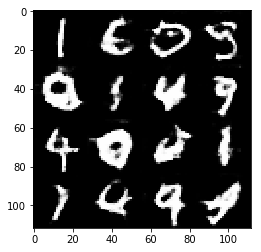

Epoch 1/2... Discriminator Loss: 1.5665... Generator Loss: 0.2866
Epoch 1/2... Discriminator Loss: 0.9722... Generator Loss: 0.6434
Epoch 1/2... Discriminator Loss: 0.9479... Generator Loss: 0.6014
Epoch 1/2... Discriminator Loss: 4.0252... Generator Loss: 5.4537
Epoch 1/2... Discriminator Loss: 1.0534... Generator Loss: 0.6283
Epoch 1/2... Discriminator Loss: 1.0173... Generator Loss: 0.6357
Epoch 1/2... Discriminator Loss: 0.8912... Generator Loss: 1.7499
Epoch 1/2... Discriminator Loss: 1.0717... Generator Loss: 0.5758
Epoch 1/2... Discriminator Loss: 0.6266... Generator Loss: 1.2591
Epoch 1/2... Discriminator Loss: 1.1482... Generator Loss: 2.1644


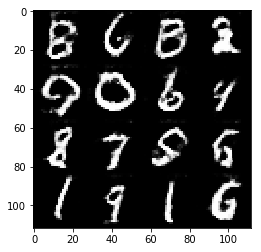

Epoch 1/2... Discriminator Loss: 0.8889... Generator Loss: 0.7326
Epoch 1/2... Discriminator Loss: 1.1049... Generator Loss: 0.5618
Epoch 1/2... Discriminator Loss: 1.4237... Generator Loss: 0.3905
Epoch 1/2... Discriminator Loss: 1.0461... Generator Loss: 1.5609
Epoch 1/2... Discriminator Loss: 1.2940... Generator Loss: 0.4124
Epoch 1/2... Discriminator Loss: 1.1030... Generator Loss: 1.2765
Epoch 1/2... Discriminator Loss: 0.9763... Generator Loss: 0.8578
Epoch 1/2... Discriminator Loss: 0.9238... Generator Loss: 0.8424
Epoch 1/2... Discriminator Loss: 0.9849... Generator Loss: 0.6989
Epoch 1/2... Discriminator Loss: 1.3926... Generator Loss: 0.3989


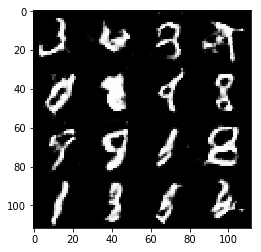

Epoch 1/2... Discriminator Loss: 1.4119... Generator Loss: 3.1193
Epoch 1/2... Discriminator Loss: 1.2724... Generator Loss: 0.4107
Epoch 1/2... Discriminator Loss: 0.7486... Generator Loss: 0.9370
Epoch 1/2... Discriminator Loss: 0.9446... Generator Loss: 0.6279
Epoch 1/2... Discriminator Loss: 2.0939... Generator Loss: 0.1707
Epoch 1/2... Discriminator Loss: 1.0802... Generator Loss: 0.5843
Epoch 1/2... Discriminator Loss: 1.0416... Generator Loss: 0.5587
Epoch 1/2... Discriminator Loss: 1.2951... Generator Loss: 0.4260
Epoch 1/2... Discriminator Loss: 0.9471... Generator Loss: 0.6418
Epoch 1/2... Discriminator Loss: 0.9450... Generator Loss: 0.8314


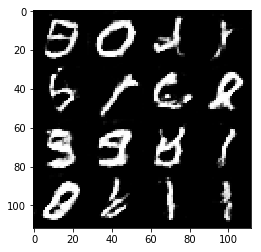

Epoch 1/2... Discriminator Loss: 1.7984... Generator Loss: 0.2337
Epoch 1/2... Discriminator Loss: 1.1179... Generator Loss: 2.7076
Epoch 1/2... Discriminator Loss: 1.1595... Generator Loss: 0.4581
Epoch 1/2... Discriminator Loss: 0.9431... Generator Loss: 1.1478
Epoch 1/2... Discriminator Loss: 0.8972... Generator Loss: 1.3446
Epoch 1/2... Discriminator Loss: 0.7189... Generator Loss: 1.7504
Epoch 1/2... Discriminator Loss: 1.1207... Generator Loss: 1.7097
Epoch 1/2... Discriminator Loss: 1.5780... Generator Loss: 0.3029
Epoch 1/2... Discriminator Loss: 0.8331... Generator Loss: 0.8149
Epoch 1/2... Discriminator Loss: 0.7820... Generator Loss: 0.9127


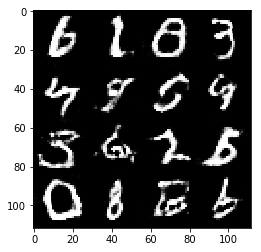

Epoch 1/2... Discriminator Loss: 0.9196... Generator Loss: 0.6683
Epoch 1/2... Discriminator Loss: 0.5328... Generator Loss: 1.2064
Epoch 1/2... Discriminator Loss: 1.2015... Generator Loss: 0.5431
Epoch 1/2... Discriminator Loss: 0.6345... Generator Loss: 1.0586
Epoch 1/2... Discriminator Loss: 0.5742... Generator Loss: 1.6032
Epoch 1/2... Discriminator Loss: 1.1197... Generator Loss: 0.4709
Epoch 1/2... Discriminator Loss: 0.6414... Generator Loss: 1.1105
Epoch 2/2... Discriminator Loss: 0.6772... Generator Loss: 1.4083
Epoch 2/2... Discriminator Loss: 2.0817... Generator Loss: 0.1683
Epoch 2/2... Discriminator Loss: 0.6828... Generator Loss: 1.1070


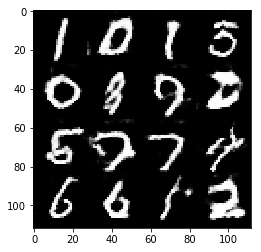

Epoch 2/2... Discriminator Loss: 0.8300... Generator Loss: 0.7344
Epoch 2/2... Discriminator Loss: 0.8180... Generator Loss: 0.7973
Epoch 2/2... Discriminator Loss: 0.5682... Generator Loss: 1.3005
Epoch 2/2... Discriminator Loss: 0.7587... Generator Loss: 0.8058
Epoch 2/2... Discriminator Loss: 2.5678... Generator Loss: 4.2732
Epoch 2/2... Discriminator Loss: 1.2820... Generator Loss: 0.4195
Epoch 2/2... Discriminator Loss: 0.7097... Generator Loss: 0.9198
Epoch 2/2... Discriminator Loss: 0.6394... Generator Loss: 1.0956
Epoch 2/2... Discriminator Loss: 0.8496... Generator Loss: 0.7547
Epoch 2/2... Discriminator Loss: 2.1477... Generator Loss: 3.6044


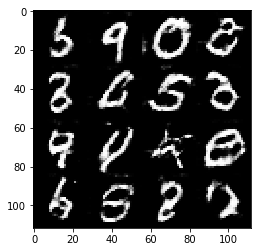

Epoch 2/2... Discriminator Loss: 1.1332... Generator Loss: 0.4945
Epoch 2/2... Discriminator Loss: 0.6223... Generator Loss: 1.1288
Epoch 2/2... Discriminator Loss: 0.9759... Generator Loss: 0.7824
Epoch 2/2... Discriminator Loss: 1.1375... Generator Loss: 0.5174
Epoch 2/2... Discriminator Loss: 0.8249... Generator Loss: 1.2606
Epoch 2/2... Discriminator Loss: 0.9076... Generator Loss: 0.9189
Epoch 2/2... Discriminator Loss: 1.5969... Generator Loss: 0.3156
Epoch 2/2... Discriminator Loss: 1.1075... Generator Loss: 0.5403
Epoch 2/2... Discriminator Loss: 1.2255... Generator Loss: 0.4897
Epoch 2/2... Discriminator Loss: 1.4241... Generator Loss: 0.3426


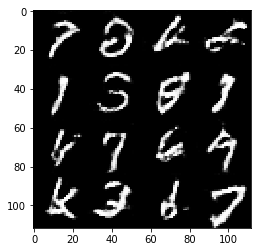

Epoch 2/2... Discriminator Loss: 0.8519... Generator Loss: 0.7662
Epoch 2/2... Discriminator Loss: 1.2253... Generator Loss: 0.4862
Epoch 2/2... Discriminator Loss: 1.5635... Generator Loss: 0.2892
Epoch 2/2... Discriminator Loss: 1.0813... Generator Loss: 0.5790
Epoch 2/2... Discriminator Loss: 0.8997... Generator Loss: 0.7398
Epoch 2/2... Discriminator Loss: 1.0432... Generator Loss: 0.5243
Epoch 2/2... Discriminator Loss: 2.5921... Generator Loss: 0.1018
Epoch 2/2... Discriminator Loss: 0.9477... Generator Loss: 0.6927
Epoch 2/2... Discriminator Loss: 1.2005... Generator Loss: 2.7979
Epoch 2/2... Discriminator Loss: 0.6070... Generator Loss: 1.0175


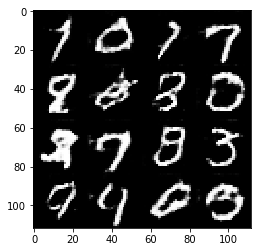

Epoch 2/2... Discriminator Loss: 1.2899... Generator Loss: 2.3986
Epoch 2/2... Discriminator Loss: 0.7198... Generator Loss: 1.5070
Epoch 2/2... Discriminator Loss: 0.6889... Generator Loss: 1.1281
Epoch 2/2... Discriminator Loss: 0.7384... Generator Loss: 0.9044
Epoch 2/2... Discriminator Loss: 0.6650... Generator Loss: 1.0507
Epoch 2/2... Discriminator Loss: 0.8203... Generator Loss: 2.3634
Epoch 2/2... Discriminator Loss: 0.6356... Generator Loss: 1.4854
Epoch 2/2... Discriminator Loss: 0.9713... Generator Loss: 0.7044
Epoch 2/2... Discriminator Loss: 0.7323... Generator Loss: 0.9156
Epoch 2/2... Discriminator Loss: 0.8644... Generator Loss: 0.7392


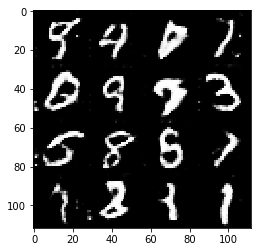

Epoch 2/2... Discriminator Loss: 0.7461... Generator Loss: 0.8910
Epoch 2/2... Discriminator Loss: 1.0064... Generator Loss: 2.8849
Epoch 2/2... Discriminator Loss: 1.3618... Generator Loss: 0.4083
Epoch 2/2... Discriminator Loss: 0.7738... Generator Loss: 0.8899
Epoch 2/2... Discriminator Loss: 0.9031... Generator Loss: 0.7231
Epoch 2/2... Discriminator Loss: 0.4430... Generator Loss: 1.4378
Epoch 2/2... Discriminator Loss: 0.8976... Generator Loss: 2.2041
Epoch 2/2... Discriminator Loss: 0.7853... Generator Loss: 2.9185
Epoch 2/2... Discriminator Loss: 0.6309... Generator Loss: 1.2445
Epoch 2/2... Discriminator Loss: 1.2998... Generator Loss: 0.4329


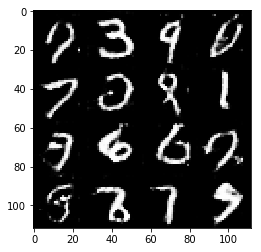

Epoch 2/2... Discriminator Loss: 0.9169... Generator Loss: 0.6988
Epoch 2/2... Discriminator Loss: 0.7274... Generator Loss: 3.2993
Epoch 2/2... Discriminator Loss: 0.8262... Generator Loss: 0.9665
Epoch 2/2... Discriminator Loss: 0.9058... Generator Loss: 0.6459
Epoch 2/2... Discriminator Loss: 0.7540... Generator Loss: 0.8220
Epoch 2/2... Discriminator Loss: 0.9416... Generator Loss: 0.6836
Epoch 2/2... Discriminator Loss: 0.5329... Generator Loss: 1.1270
Epoch 2/2... Discriminator Loss: 0.7313... Generator Loss: 0.7897
Epoch 2/2... Discriminator Loss: 0.7632... Generator Loss: 0.8493
Epoch 2/2... Discriminator Loss: 1.5515... Generator Loss: 4.2082


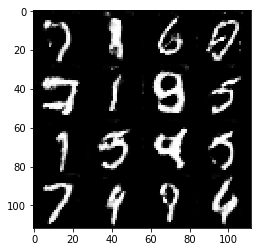

Epoch 2/2... Discriminator Loss: 0.7303... Generator Loss: 1.8401
Epoch 2/2... Discriminator Loss: 0.5812... Generator Loss: 1.3174
Epoch 2/2... Discriminator Loss: 0.6848... Generator Loss: 1.0175
Epoch 2/2... Discriminator Loss: 0.7413... Generator Loss: 0.9543
Epoch 2/2... Discriminator Loss: 2.9423... Generator Loss: 0.0817
Epoch 2/2... Discriminator Loss: 1.0184... Generator Loss: 0.6137
Epoch 2/2... Discriminator Loss: 1.3255... Generator Loss: 0.3841
Epoch 2/2... Discriminator Loss: 0.7313... Generator Loss: 1.0207
Epoch 2/2... Discriminator Loss: 2.3514... Generator Loss: 0.1296
Epoch 2/2... Discriminator Loss: 0.7397... Generator Loss: 0.8932


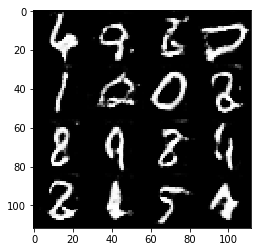

Epoch 2/2... Discriminator Loss: 0.7095... Generator Loss: 1.0480
Epoch 2/2... Discriminator Loss: 0.9438... Generator Loss: 0.6619
Epoch 2/2... Discriminator Loss: 0.8583... Generator Loss: 0.7934
Epoch 2/2... Discriminator Loss: 0.7998... Generator Loss: 0.8494
Epoch 2/2... Discriminator Loss: 0.7958... Generator Loss: 0.7862
Epoch 2/2... Discriminator Loss: 1.7103... Generator Loss: 0.2778
Epoch 2/2... Discriminator Loss: 0.6553... Generator Loss: 1.2610
Epoch 2/2... Discriminator Loss: 0.6727... Generator Loss: 0.9814
Epoch 2/2... Discriminator Loss: 0.8844... Generator Loss: 0.9220
Epoch 2/2... Discriminator Loss: 0.7266... Generator Loss: 0.8628


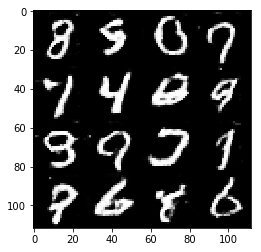

Epoch 2/2... Discriminator Loss: 0.6493... Generator Loss: 0.9080
Epoch 2/2... Discriminator Loss: 0.6864... Generator Loss: 0.8699
Epoch 2/2... Discriminator Loss: 0.7997... Generator Loss: 0.8294
Epoch 2/2... Discriminator Loss: 0.4950... Generator Loss: 1.3862
Epoch 2/2... Discriminator Loss: 0.9590... Generator Loss: 0.5835
Epoch 2/2... Discriminator Loss: 1.0080... Generator Loss: 0.7025
Epoch 2/2... Discriminator Loss: 0.6982... Generator Loss: 0.9724
Epoch 2/2... Discriminator Loss: 0.5489... Generator Loss: 1.9828
Epoch 2/2... Discriminator Loss: 0.6636... Generator Loss: 1.0028
Epoch 2/2... Discriminator Loss: 0.6407... Generator Loss: 2.0525


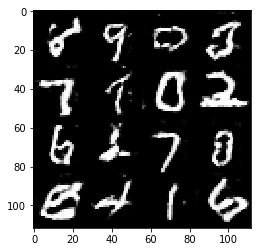

Epoch 2/2... Discriminator Loss: 0.9420... Generator Loss: 0.6767
Epoch 2/2... Discriminator Loss: 0.7788... Generator Loss: 0.8231
Epoch 2/2... Discriminator Loss: 0.6040... Generator Loss: 1.0527
Epoch 2/2... Discriminator Loss: 2.8233... Generator Loss: 0.1193
Epoch 2/2... Discriminator Loss: 0.5748... Generator Loss: 1.6261
Epoch 2/2... Discriminator Loss: 0.8758... Generator Loss: 0.7522
Epoch 2/2... Discriminator Loss: 1.4351... Generator Loss: 0.3295
Epoch 2/2... Discriminator Loss: 1.2982... Generator Loss: 0.4229
Epoch 2/2... Discriminator Loss: 1.1660... Generator Loss: 0.4703
Epoch 2/2... Discriminator Loss: 0.9662... Generator Loss: 0.6308


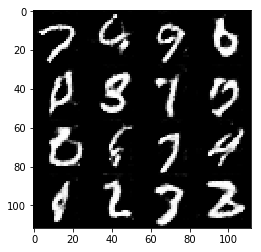

Epoch 2/2... Discriminator Loss: 0.5590... Generator Loss: 1.1215
Epoch 2/2... Discriminator Loss: 0.3887... Generator Loss: 1.4576
Epoch 2/2... Discriminator Loss: 0.6126... Generator Loss: 0.9495
Epoch 2/2... Discriminator Loss: 1.9402... Generator Loss: 5.2320
Epoch 2/2... Discriminator Loss: 1.2484... Generator Loss: 3.4932
Epoch 2/2... Discriminator Loss: 0.6591... Generator Loss: 1.0526
Epoch 2/2... Discriminator Loss: 0.7010... Generator Loss: 1.0235
Epoch 2/2... Discriminator Loss: 0.8460... Generator Loss: 0.7623
Epoch 2/2... Discriminator Loss: 0.6203... Generator Loss: 1.4003
Epoch 2/2... Discriminator Loss: 0.4754... Generator Loss: 1.2395


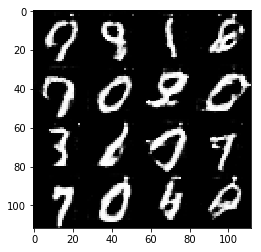

Epoch 2/2... Discriminator Loss: 1.2021... Generator Loss: 0.4439
Epoch 2/2... Discriminator Loss: 1.2237... Generator Loss: 0.5055
Epoch 2/2... Discriminator Loss: 1.0873... Generator Loss: 2.6290
Epoch 2/2... Discriminator Loss: 0.5079... Generator Loss: 1.3606
Epoch 2/2... Discriminator Loss: 0.6482... Generator Loss: 1.0364
Epoch 2/2... Discriminator Loss: 0.3011... Generator Loss: 2.0138
Epoch 2/2... Discriminator Loss: 0.7506... Generator Loss: 1.0564
Epoch 2/2... Discriminator Loss: 0.8443... Generator Loss: 0.7357
Epoch 2/2... Discriminator Loss: 0.3801... Generator Loss: 1.5792
Epoch 2/2... Discriminator Loss: 0.6240... Generator Loss: 1.5401


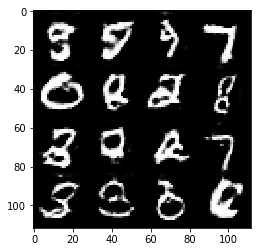

Epoch 2/2... Discriminator Loss: 0.4274... Generator Loss: 2.0658
Epoch 2/2... Discriminator Loss: 0.5108... Generator Loss: 1.3783
Epoch 2/2... Discriminator Loss: 0.8262... Generator Loss: 0.8152
Epoch 2/2... Discriminator Loss: 1.4054... Generator Loss: 0.3817
Epoch 2/2... Discriminator Loss: 0.7154... Generator Loss: 0.9595
Epoch 2/2... Discriminator Loss: 0.8991... Generator Loss: 0.6755
Epoch 2/2... Discriminator Loss: 0.5802... Generator Loss: 1.1480
Epoch 2/2... Discriminator Loss: 0.7647... Generator Loss: 0.8451
Epoch 2/2... Discriminator Loss: 0.8537... Generator Loss: 2.5637
Epoch 2/2... Discriminator Loss: 0.6812... Generator Loss: 1.5389


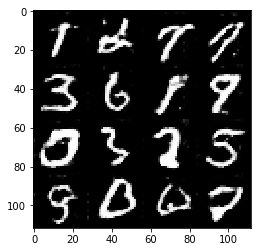

Epoch 2/2... Discriminator Loss: 1.2710... Generator Loss: 0.4578
Epoch 2/2... Discriminator Loss: 1.6002... Generator Loss: 0.5121
Epoch 2/2... Discriminator Loss: 0.6676... Generator Loss: 1.0030
Epoch 2/2... Discriminator Loss: 0.5384... Generator Loss: 1.1366
Epoch 2/2... Discriminator Loss: 0.5505... Generator Loss: 1.3862
Epoch 2/2... Discriminator Loss: 1.0317... Generator Loss: 0.5954
Epoch 2/2... Discriminator Loss: 0.5304... Generator Loss: 1.3639
Epoch 2/2... Discriminator Loss: 0.4567... Generator Loss: 1.4200
Epoch 2/2... Discriminator Loss: 1.2701... Generator Loss: 0.4229
Epoch 2/2... Discriminator Loss: 2.8763... Generator Loss: 0.1259


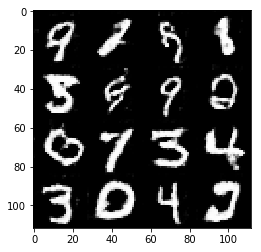

Epoch 2/2... Discriminator Loss: 1.0099... Generator Loss: 0.6364
Epoch 2/2... Discriminator Loss: 0.5983... Generator Loss: 1.2316
Epoch 2/2... Discriminator Loss: 0.6331... Generator Loss: 1.0748
Epoch 2/2... Discriminator Loss: 1.1448... Generator Loss: 0.5103
Epoch 2/2... Discriminator Loss: 0.7428... Generator Loss: 0.8904
Epoch 2/2... Discriminator Loss: 0.9444... Generator Loss: 0.7177
Epoch 2/2... Discriminator Loss: 0.5938... Generator Loss: 1.1714
Epoch 2/2... Discriminator Loss: 1.3511... Generator Loss: 0.4736
Epoch 2/2... Discriminator Loss: 0.7904... Generator Loss: 0.8644
Epoch 2/2... Discriminator Loss: 0.5665... Generator Loss: 1.2512


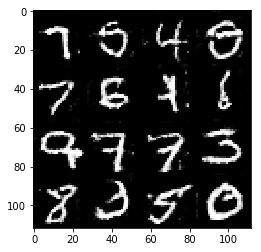

Epoch 2/2... Discriminator Loss: 0.4344... Generator Loss: 1.5857
Epoch 2/2... Discriminator Loss: 0.5598... Generator Loss: 1.3590
Epoch 2/2... Discriminator Loss: 0.4662... Generator Loss: 1.5623
Epoch 2/2... Discriminator Loss: 0.9515... Generator Loss: 0.6980
Epoch 2/2... Discriminator Loss: 0.7848... Generator Loss: 0.8788
Epoch 2/2... Discriminator Loss: 1.3774... Generator Loss: 3.6616
Epoch 2/2... Discriminator Loss: 0.7716... Generator Loss: 1.3284
Epoch 2/2... Discriminator Loss: 0.8228... Generator Loss: 0.7788
Epoch 2/2... Discriminator Loss: 0.6374... Generator Loss: 0.9542
Epoch 2/2... Discriminator Loss: 0.7107... Generator Loss: 0.9919


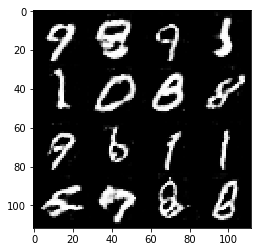

Epoch 2/2... Discriminator Loss: 0.5808... Generator Loss: 1.0899
Epoch 2/2... Discriminator Loss: 0.9750... Generator Loss: 0.5908
Epoch 2/2... Discriminator Loss: 0.7923... Generator Loss: 0.8433
Epoch 2/2... Discriminator Loss: 1.6946... Generator Loss: 0.2666
Epoch 2/2... Discriminator Loss: 2.1189... Generator Loss: 5.6650
Epoch 2/2... Discriminator Loss: 0.6476... Generator Loss: 1.0882
Epoch 2/2... Discriminator Loss: 0.7035... Generator Loss: 0.9922
Epoch 2/2... Discriminator Loss: 0.7681... Generator Loss: 0.7916
Epoch 2/2... Discriminator Loss: 0.6462... Generator Loss: 1.0200
Epoch 2/2... Discriminator Loss: 0.7584... Generator Loss: 0.8825


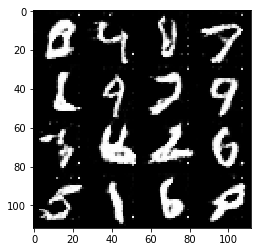

Epoch 2/2... Discriminator Loss: 0.8545... Generator Loss: 0.7103
Epoch 2/2... Discriminator Loss: 1.5148... Generator Loss: 0.4279
Epoch 2/2... Discriminator Loss: 2.2496... Generator Loss: 0.1921
Epoch 2/2... Discriminator Loss: 0.9180... Generator Loss: 0.7255
Epoch 2/2... Discriminator Loss: 0.5098... Generator Loss: 1.5363
Epoch 2/2... Discriminator Loss: 0.8207... Generator Loss: 0.7665
Epoch 2/2... Discriminator Loss: 0.4010... Generator Loss: 1.8918
Epoch 2/2... Discriminator Loss: 0.5755... Generator Loss: 1.1598
Epoch 2/2... Discriminator Loss: 0.4985... Generator Loss: 1.2155
Epoch 2/2... Discriminator Loss: 0.2717... Generator Loss: 1.9363


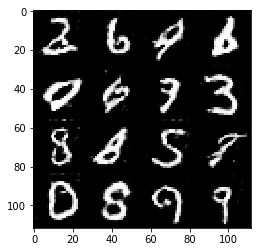

Epoch 2/2... Discriminator Loss: 0.9689... Generator Loss: 0.6249
Epoch 2/2... Discriminator Loss: 0.5392... Generator Loss: 1.2414
Epoch 2/2... Discriminator Loss: 0.6072... Generator Loss: 1.1053
Epoch 2/2... Discriminator Loss: 1.6825... Generator Loss: 4.5688
Epoch 2/2... Discriminator Loss: 0.5296... Generator Loss: 1.4030


In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.25


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/1... Discriminator Loss: 4.5888... Generator Loss: 0.0135
Epoch 1/1... Discriminator Loss: 4.0115... Generator Loss: 0.0293
Epoch 1/1... Discriminator Loss: 1.8160... Generator Loss: 9.3494
Epoch 1/1... Discriminator Loss: 4.9376... Generator Loss: 0.0110
Epoch 1/1... Discriminator Loss: 0.6582... Generator Loss: 2.0976
Epoch 1/1... Discriminator Loss: 2.6202... Generator Loss: 0.0983
Epoch 1/1... Discriminator Loss: 0.6539... Generator Loss: 6.4723
Epoch 1/1... Discriminator Loss: 0.3383... Generator Loss: 4.2185
Epoch 1/1... Discriminator Loss: 0.4962... Generator Loss: 1.6998
Epoch 1/1... Discriminator Loss: 1.1021... Generator Loss: 7.5592


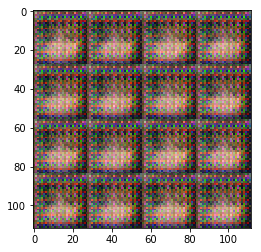

Epoch 1/1... Discriminator Loss: 0.7536... Generator Loss: 0.9711
Epoch 1/1... Discriminator Loss: 0.1368... Generator Loss: 7.0807
Epoch 1/1... Discriminator Loss: 0.6029... Generator Loss: 0.8857
Epoch 1/1... Discriminator Loss: 0.2424... Generator Loss: 5.0247
Epoch 1/1... Discriminator Loss: 0.2617... Generator Loss: 1.7387
Epoch 1/1... Discriminator Loss: 0.1740... Generator Loss: 2.0405
Epoch 1/1... Discriminator Loss: 0.1183... Generator Loss: 5.3269
Epoch 1/1... Discriminator Loss: 0.1371... Generator Loss: 2.3507
Epoch 1/1... Discriminator Loss: 0.2864... Generator Loss: 2.0357
Epoch 1/1... Discriminator Loss: 0.1358... Generator Loss: 6.7378


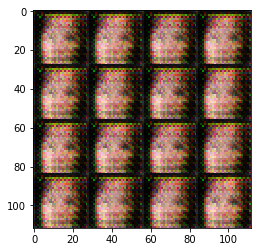

Epoch 1/1... Discriminator Loss: 0.2119... Generator Loss: 2.9438
Epoch 1/1... Discriminator Loss: 0.1908... Generator Loss: 2.3017
Epoch 1/1... Discriminator Loss: 0.1538... Generator Loss: 4.9746
Epoch 1/1... Discriminator Loss: 1.6566... Generator Loss: 0.3177
Epoch 1/1... Discriminator Loss: 1.4480... Generator Loss: 0.4257
Epoch 1/1... Discriminator Loss: 1.5658... Generator Loss: 0.4749
Epoch 1/1... Discriminator Loss: 1.3108... Generator Loss: 2.8825
Epoch 1/1... Discriminator Loss: 1.3196... Generator Loss: 4.0045
Epoch 1/1... Discriminator Loss: 0.8684... Generator Loss: 0.7281
Epoch 1/1... Discriminator Loss: 0.7299... Generator Loss: 0.8661


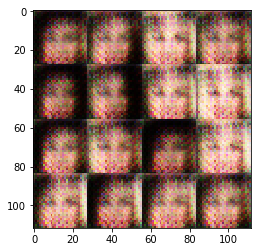

Epoch 1/1... Discriminator Loss: 1.9081... Generator Loss: 0.5481
Epoch 1/1... Discriminator Loss: 0.7667... Generator Loss: 0.8577
Epoch 1/1... Discriminator Loss: 1.5340... Generator Loss: 0.4286
Epoch 1/1... Discriminator Loss: 1.2268... Generator Loss: 1.0560
Epoch 1/1... Discriminator Loss: 0.9150... Generator Loss: 1.0090
Epoch 1/1... Discriminator Loss: 1.2292... Generator Loss: 0.8261
Epoch 1/1... Discriminator Loss: 1.6194... Generator Loss: 0.3634
Epoch 1/1... Discriminator Loss: 0.9659... Generator Loss: 1.2710
Epoch 1/1... Discriminator Loss: 0.8187... Generator Loss: 2.1771
Epoch 1/1... Discriminator Loss: 1.0842... Generator Loss: 0.5904


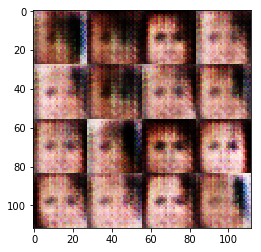

Epoch 1/1... Discriminator Loss: 0.5876... Generator Loss: 2.4870
Epoch 1/1... Discriminator Loss: 0.6284... Generator Loss: 1.0814
Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 2.2595
Epoch 1/1... Discriminator Loss: 1.5482... Generator Loss: 0.3783
Epoch 1/1... Discriminator Loss: 2.0301... Generator Loss: 0.2066
Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 0.4340
Epoch 1/1... Discriminator Loss: 1.1183... Generator Loss: 0.5615
Epoch 1/1... Discriminator Loss: 1.0051... Generator Loss: 0.8940
Epoch 1/1... Discriminator Loss: 1.3086... Generator Loss: 0.4422
Epoch 1/1... Discriminator Loss: 1.2363... Generator Loss: 1.0030


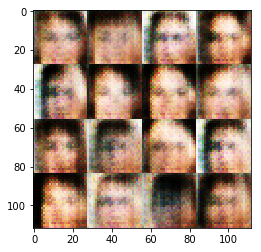

Epoch 1/1... Discriminator Loss: 1.5778... Generator Loss: 2.3382
Epoch 1/1... Discriminator Loss: 0.8868... Generator Loss: 3.9566
Epoch 1/1... Discriminator Loss: 1.2611... Generator Loss: 2.0344
Epoch 1/1... Discriminator Loss: 0.9997... Generator Loss: 0.8256
Epoch 1/1... Discriminator Loss: 2.1116... Generator Loss: 0.2721
Epoch 1/1... Discriminator Loss: 0.9863... Generator Loss: 1.4487
Epoch 1/1... Discriminator Loss: 1.6329... Generator Loss: 0.4026
Epoch 1/1... Discriminator Loss: 0.6508... Generator Loss: 1.7059
Epoch 1/1... Discriminator Loss: 1.5193... Generator Loss: 1.5235
Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 1.9684


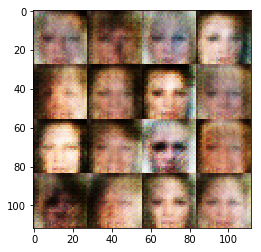

Epoch 1/1... Discriminator Loss: 0.8962... Generator Loss: 1.4103
Epoch 1/1... Discriminator Loss: 1.2127... Generator Loss: 0.6719
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.4246
Epoch 1/1... Discriminator Loss: 1.1544... Generator Loss: 0.6655
Epoch 1/1... Discriminator Loss: 1.7973... Generator Loss: 0.2282
Epoch 1/1... Discriminator Loss: 1.3549... Generator Loss: 0.4011
Epoch 1/1... Discriminator Loss: 0.9909... Generator Loss: 1.1155
Epoch 1/1... Discriminator Loss: 0.8815... Generator Loss: 2.2619
Epoch 1/1... Discriminator Loss: 1.9800... Generator Loss: 0.2730
Epoch 1/1... Discriminator Loss: 2.1945... Generator Loss: 0.1468


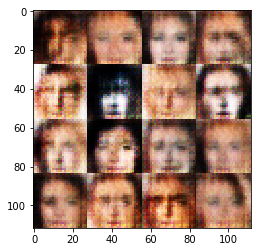

Epoch 1/1... Discriminator Loss: 1.5421... Generator Loss: 0.3388
Epoch 1/1... Discriminator Loss: 1.3466... Generator Loss: 0.7026
Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 1.0913
Epoch 1/1... Discriminator Loss: 1.4787... Generator Loss: 0.5693
Epoch 1/1... Discriminator Loss: 1.3243... Generator Loss: 1.0842
Epoch 1/1... Discriminator Loss: 1.1571... Generator Loss: 0.7459
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.4724
Epoch 1/1... Discriminator Loss: 1.1820... Generator Loss: 0.9604
Epoch 1/1... Discriminator Loss: 1.0169... Generator Loss: 1.4610
Epoch 1/1... Discriminator Loss: 1.7429... Generator Loss: 0.2555


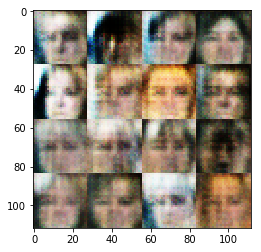

Epoch 1/1... Discriminator Loss: 1.4992... Generator Loss: 0.5118
Epoch 1/1... Discriminator Loss: 1.0774... Generator Loss: 1.2635
Epoch 1/1... Discriminator Loss: 1.4813... Generator Loss: 0.4725
Epoch 1/1... Discriminator Loss: 1.9656... Generator Loss: 0.2206
Epoch 1/1... Discriminator Loss: 1.0940... Generator Loss: 0.6655
Epoch 1/1... Discriminator Loss: 1.7473... Generator Loss: 0.3405
Epoch 1/1... Discriminator Loss: 1.0815... Generator Loss: 0.9496
Epoch 1/1... Discriminator Loss: 1.7022... Generator Loss: 0.3374
Epoch 1/1... Discriminator Loss: 1.1639... Generator Loss: 1.5708
Epoch 1/1... Discriminator Loss: 1.8346... Generator Loss: 0.2296


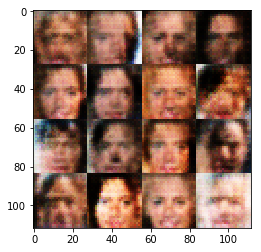

Epoch 1/1... Discriminator Loss: 1.2985... Generator Loss: 0.5059
Epoch 1/1... Discriminator Loss: 0.9840... Generator Loss: 0.7880
Epoch 1/1... Discriminator Loss: 2.4241... Generator Loss: 0.1171
Epoch 1/1... Discriminator Loss: 1.6958... Generator Loss: 0.2898
Epoch 1/1... Discriminator Loss: 1.2291... Generator Loss: 1.7416
Epoch 1/1... Discriminator Loss: 1.2677... Generator Loss: 0.4580
Epoch 1/1... Discriminator Loss: 1.9798... Generator Loss: 0.2307
Epoch 1/1... Discriminator Loss: 1.0211... Generator Loss: 0.9819
Epoch 1/1... Discriminator Loss: 1.4500... Generator Loss: 0.3582
Epoch 1/1... Discriminator Loss: 0.8845... Generator Loss: 0.8427


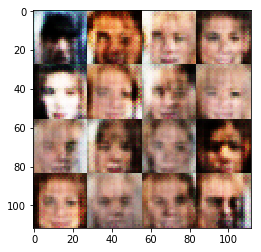

Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 1.4487
Epoch 1/1... Discriminator Loss: 0.8548... Generator Loss: 1.4307
Epoch 1/1... Discriminator Loss: 0.9519... Generator Loss: 1.1594
Epoch 1/1... Discriminator Loss: 1.2603... Generator Loss: 0.8692
Epoch 1/1... Discriminator Loss: 1.5041... Generator Loss: 0.3635
Epoch 1/1... Discriminator Loss: 0.8057... Generator Loss: 0.9471
Epoch 1/1... Discriminator Loss: 1.0542... Generator Loss: 0.9517
Epoch 1/1... Discriminator Loss: 0.6388... Generator Loss: 1.4844
Epoch 1/1... Discriminator Loss: 1.0158... Generator Loss: 1.8340
Epoch 1/1... Discriminator Loss: 0.8578... Generator Loss: 2.4292


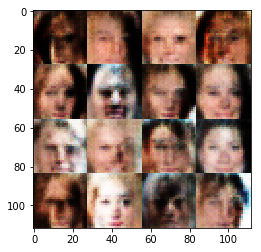

Epoch 1/1... Discriminator Loss: 1.7837... Generator Loss: 3.4394
Epoch 1/1... Discriminator Loss: 2.3371... Generator Loss: 0.1169
Epoch 1/1... Discriminator Loss: 0.6408... Generator Loss: 1.3240
Epoch 1/1... Discriminator Loss: 0.9383... Generator Loss: 0.7316
Epoch 1/1... Discriminator Loss: 1.0726... Generator Loss: 0.8029
Epoch 1/1... Discriminator Loss: 1.3267... Generator Loss: 0.4254
Epoch 1/1... Discriminator Loss: 1.4640... Generator Loss: 0.3566
Epoch 1/1... Discriminator Loss: 0.9600... Generator Loss: 0.8192
Epoch 1/1... Discriminator Loss: 0.9998... Generator Loss: 1.3417
Epoch 1/1... Discriminator Loss: 1.1674... Generator Loss: 0.9809


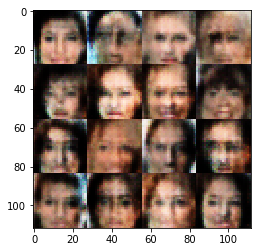

Epoch 1/1... Discriminator Loss: 0.7095... Generator Loss: 0.9685
Epoch 1/1... Discriminator Loss: 0.6508... Generator Loss: 2.6700
Epoch 1/1... Discriminator Loss: 1.7540... Generator Loss: 2.2019
Epoch 1/1... Discriminator Loss: 0.8887... Generator Loss: 1.0057
Epoch 1/1... Discriminator Loss: 1.5764... Generator Loss: 0.4168
Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.4380
Epoch 1/1... Discriminator Loss: 1.4955... Generator Loss: 0.3437
Epoch 1/1... Discriminator Loss: 1.1329... Generator Loss: 0.7472
Epoch 1/1... Discriminator Loss: 0.8550... Generator Loss: 0.8772
Epoch 1/1... Discriminator Loss: 0.7315... Generator Loss: 1.2752


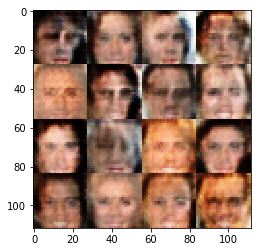

Epoch 1/1... Discriminator Loss: 1.1817... Generator Loss: 0.5476
Epoch 1/1... Discriminator Loss: 1.5879... Generator Loss: 0.2909
Epoch 1/1... Discriminator Loss: 1.1796... Generator Loss: 2.4482
Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.4388
Epoch 1/1... Discriminator Loss: 0.7430... Generator Loss: 2.0146
Epoch 1/1... Discriminator Loss: 1.2944... Generator Loss: 0.5681
Epoch 1/1... Discriminator Loss: 0.9851... Generator Loss: 1.0883
Epoch 1/1... Discriminator Loss: 1.0114... Generator Loss: 0.8438
Epoch 1/1... Discriminator Loss: 1.5520... Generator Loss: 0.2967
Epoch 1/1... Discriminator Loss: 0.8813... Generator Loss: 2.5415


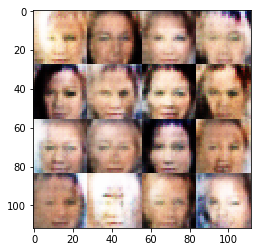

Epoch 1/1... Discriminator Loss: 0.7742... Generator Loss: 1.0487
Epoch 1/1... Discriminator Loss: 1.8913... Generator Loss: 0.2042
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.3674
Epoch 1/1... Discriminator Loss: 0.8672... Generator Loss: 1.0016
Epoch 1/1... Discriminator Loss: 1.0707... Generator Loss: 0.6010
Epoch 1/1... Discriminator Loss: 0.6520... Generator Loss: 1.2669
Epoch 1/1... Discriminator Loss: 0.5530... Generator Loss: 2.1704
Epoch 1/1... Discriminator Loss: 1.8477... Generator Loss: 0.2031
Epoch 1/1... Discriminator Loss: 1.2098... Generator Loss: 1.1089
Epoch 1/1... Discriminator Loss: 1.9421... Generator Loss: 0.1933


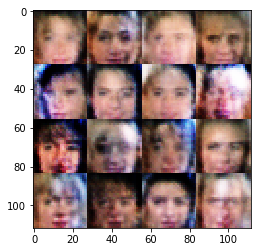

Epoch 1/1... Discriminator Loss: 1.8159... Generator Loss: 0.2095
Epoch 1/1... Discriminator Loss: 0.7321... Generator Loss: 1.6839
Epoch 1/1... Discriminator Loss: 1.0775... Generator Loss: 1.2558
Epoch 1/1... Discriminator Loss: 1.5409... Generator Loss: 0.4069
Epoch 1/1... Discriminator Loss: 0.9484... Generator Loss: 0.7950
Epoch 1/1... Discriminator Loss: 0.9893... Generator Loss: 2.1840
Epoch 1/1... Discriminator Loss: 1.6099... Generator Loss: 0.3259
Epoch 1/1... Discriminator Loss: 0.4525... Generator Loss: 2.2102
Epoch 1/1... Discriminator Loss: 1.1149... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 0.3055


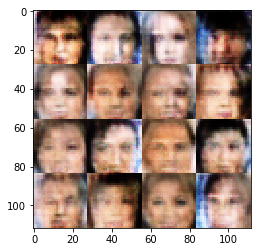

Epoch 1/1... Discriminator Loss: 1.2833... Generator Loss: 0.7711
Epoch 1/1... Discriminator Loss: 1.0254... Generator Loss: 0.8155
Epoch 1/1... Discriminator Loss: 1.0644... Generator Loss: 0.9997
Epoch 1/1... Discriminator Loss: 1.2908... Generator Loss: 0.8475
Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 0.5414
Epoch 1/1... Discriminator Loss: 0.5325... Generator Loss: 1.4430
Epoch 1/1... Discriminator Loss: 1.3326... Generator Loss: 2.3565
Epoch 1/1... Discriminator Loss: 0.9082... Generator Loss: 0.7292
Epoch 1/1... Discriminator Loss: 1.1623... Generator Loss: 0.6949
Epoch 1/1... Discriminator Loss: 1.0771... Generator Loss: 0.7668


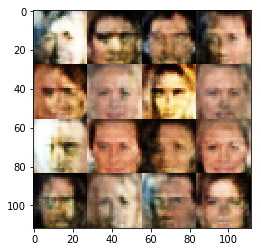

Epoch 1/1... Discriminator Loss: 1.6297... Generator Loss: 0.2844
Epoch 1/1... Discriminator Loss: 1.8857... Generator Loss: 0.2168
Epoch 1/1... Discriminator Loss: 1.1159... Generator Loss: 0.6199
Epoch 1/1... Discriminator Loss: 1.1166... Generator Loss: 0.7583
Epoch 1/1... Discriminator Loss: 1.0287... Generator Loss: 0.6721
Epoch 1/1... Discriminator Loss: 1.1399... Generator Loss: 0.5744
Epoch 1/1... Discriminator Loss: 1.1526... Generator Loss: 0.6528
Epoch 1/1... Discriminator Loss: 1.2490... Generator Loss: 0.4558
Epoch 1/1... Discriminator Loss: 1.1749... Generator Loss: 0.5941
Epoch 1/1... Discriminator Loss: 0.9981... Generator Loss: 0.9318


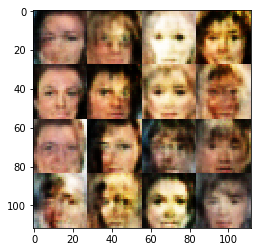

Epoch 1/1... Discriminator Loss: 1.1363... Generator Loss: 1.0875
Epoch 1/1... Discriminator Loss: 1.1915... Generator Loss: 2.2342
Epoch 1/1... Discriminator Loss: 1.0501... Generator Loss: 0.6994
Epoch 1/1... Discriminator Loss: 0.9715... Generator Loss: 2.1751
Epoch 1/1... Discriminator Loss: 0.8909... Generator Loss: 0.9036
Epoch 1/1... Discriminator Loss: 0.6232... Generator Loss: 1.2330
Epoch 1/1... Discriminator Loss: 0.6486... Generator Loss: 2.2691
Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 0.5979
Epoch 1/1... Discriminator Loss: 0.6695... Generator Loss: 1.5692
Epoch 1/1... Discriminator Loss: 1.2403... Generator Loss: 0.4370


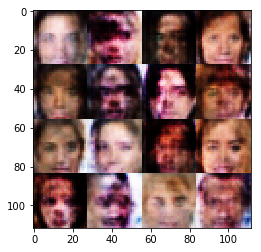

Epoch 1/1... Discriminator Loss: 1.2361... Generator Loss: 0.6374
Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.6330
Epoch 1/1... Discriminator Loss: 1.7293... Generator Loss: 0.2548
Epoch 1/1... Discriminator Loss: 0.8315... Generator Loss: 1.6647
Epoch 1/1... Discriminator Loss: 1.6974... Generator Loss: 0.2915
Epoch 1/1... Discriminator Loss: 1.0557... Generator Loss: 0.9831
Epoch 1/1... Discriminator Loss: 1.5738... Generator Loss: 0.3096
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.4466
Epoch 1/1... Discriminator Loss: 0.9546... Generator Loss: 0.7636
Epoch 1/1... Discriminator Loss: 1.1208... Generator Loss: 0.5757


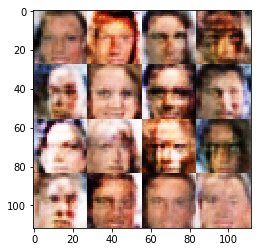

Epoch 1/1... Discriminator Loss: 1.8019... Generator Loss: 0.2365
Epoch 1/1... Discriminator Loss: 0.9796... Generator Loss: 1.6461
Epoch 1/1... Discriminator Loss: 0.8546... Generator Loss: 0.9711
Epoch 1/1... Discriminator Loss: 0.6407... Generator Loss: 1.2923
Epoch 1/1... Discriminator Loss: 1.2276... Generator Loss: 0.6747
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 1.8275
Epoch 1/1... Discriminator Loss: 1.6506... Generator Loss: 0.2838
Epoch 1/1... Discriminator Loss: 0.8580... Generator Loss: 1.0936
Epoch 1/1... Discriminator Loss: 1.2960... Generator Loss: 0.4836
Epoch 1/1... Discriminator Loss: 1.6131... Generator Loss: 0.3459


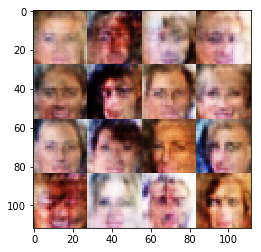

Epoch 1/1... Discriminator Loss: 0.8766... Generator Loss: 1.0438
Epoch 1/1... Discriminator Loss: 1.1489... Generator Loss: 0.6336
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.3613
Epoch 1/1... Discriminator Loss: 0.9920... Generator Loss: 1.0176
Epoch 1/1... Discriminator Loss: 1.6272... Generator Loss: 0.2519
Epoch 1/1... Discriminator Loss: 0.9112... Generator Loss: 1.1943
Epoch 1/1... Discriminator Loss: 1.2957... Generator Loss: 0.5095
Epoch 1/1... Discriminator Loss: 1.2312... Generator Loss: 0.5162
Epoch 1/1... Discriminator Loss: 0.6878... Generator Loss: 1.5776
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.4661


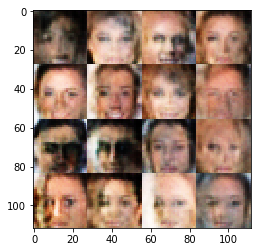

Epoch 1/1... Discriminator Loss: 2.2736... Generator Loss: 0.1293
Epoch 1/1... Discriminator Loss: 0.9551... Generator Loss: 0.7472
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.7635
Epoch 1/1... Discriminator Loss: 1.0185... Generator Loss: 0.8755
Epoch 1/1... Discriminator Loss: 1.6545... Generator Loss: 0.3138
Epoch 1/1... Discriminator Loss: 1.4862... Generator Loss: 0.4102
Epoch 1/1... Discriminator Loss: 1.7859... Generator Loss: 0.2541
Epoch 1/1... Discriminator Loss: 0.9242... Generator Loss: 0.9585
Epoch 1/1... Discriminator Loss: 1.7869... Generator Loss: 0.2570
Epoch 1/1... Discriminator Loss: 0.8989... Generator Loss: 0.9727


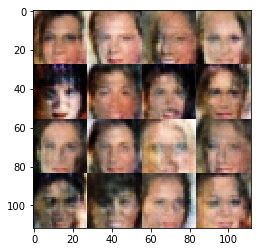

Epoch 1/1... Discriminator Loss: 0.7133... Generator Loss: 1.4152
Epoch 1/1... Discriminator Loss: 1.4673... Generator Loss: 0.3436
Epoch 1/1... Discriminator Loss: 1.5362... Generator Loss: 0.3558
Epoch 1/1... Discriminator Loss: 1.0556... Generator Loss: 0.8675
Epoch 1/1... Discriminator Loss: 1.2114... Generator Loss: 0.8055
Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 0.8712
Epoch 1/1... Discriminator Loss: 1.5078... Generator Loss: 0.3449
Epoch 1/1... Discriminator Loss: 0.9855... Generator Loss: 1.0764
Epoch 1/1... Discriminator Loss: 0.9874... Generator Loss: 0.9388
Epoch 1/1... Discriminator Loss: 0.7973... Generator Loss: 1.0378


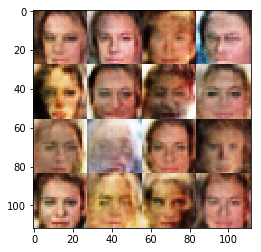

Epoch 1/1... Discriminator Loss: 1.4570... Generator Loss: 0.3963
Epoch 1/1... Discriminator Loss: 1.6742... Generator Loss: 0.3008
Epoch 1/1... Discriminator Loss: 1.4822... Generator Loss: 0.3944
Epoch 1/1... Discriminator Loss: 1.2789... Generator Loss: 0.5169
Epoch 1/1... Discriminator Loss: 0.7400... Generator Loss: 1.2524
Epoch 1/1... Discriminator Loss: 1.0738... Generator Loss: 0.6319
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.3202
Epoch 1/1... Discriminator Loss: 0.7749... Generator Loss: 1.0389
Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.4800
Epoch 1/1... Discriminator Loss: 0.7418... Generator Loss: 1.0135


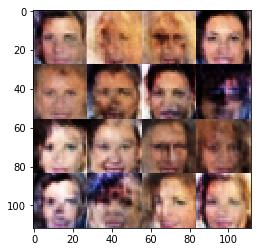

Epoch 1/1... Discriminator Loss: 1.0222... Generator Loss: 0.6488
Epoch 1/1... Discriminator Loss: 0.9449... Generator Loss: 1.2006
Epoch 1/1... Discriminator Loss: 1.1673... Generator Loss: 0.6523
Epoch 1/1... Discriminator Loss: 0.9701... Generator Loss: 0.8067
Epoch 1/1... Discriminator Loss: 1.2682... Generator Loss: 0.5374
Epoch 1/1... Discriminator Loss: 1.0847... Generator Loss: 1.1240
Epoch 1/1... Discriminator Loss: 1.3372... Generator Loss: 0.4463
Epoch 1/1... Discriminator Loss: 1.7619... Generator Loss: 0.2611
Epoch 1/1... Discriminator Loss: 1.3151... Generator Loss: 0.4591
Epoch 1/1... Discriminator Loss: 1.0560... Generator Loss: 0.9771


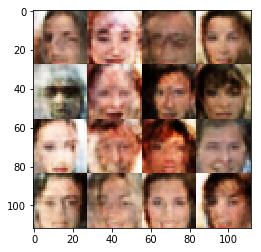

Epoch 1/1... Discriminator Loss: 1.2718... Generator Loss: 0.4714
Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.6472
Epoch 1/1... Discriminator Loss: 1.2609... Generator Loss: 0.8018
Epoch 1/1... Discriminator Loss: 0.9931... Generator Loss: 0.7838
Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 0.7447
Epoch 1/1... Discriminator Loss: 1.0010... Generator Loss: 0.8653
Epoch 1/1... Discriminator Loss: 1.8677... Generator Loss: 0.2118
Epoch 1/1... Discriminator Loss: 1.0124... Generator Loss: 0.7431
Epoch 1/1... Discriminator Loss: 0.8606... Generator Loss: 1.2868
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.5717


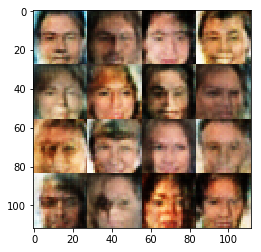

Epoch 1/1... Discriminator Loss: 1.1992... Generator Loss: 0.4595
Epoch 1/1... Discriminator Loss: 1.1221... Generator Loss: 0.6333
Epoch 1/1... Discriminator Loss: 0.8700... Generator Loss: 1.0426
Epoch 1/1... Discriminator Loss: 1.2944... Generator Loss: 0.4303
Epoch 1/1... Discriminator Loss: 1.2667... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 1.2897... Generator Loss: 0.8146
Epoch 1/1... Discriminator Loss: 1.2553... Generator Loss: 0.6498
Epoch 1/1... Discriminator Loss: 1.0840... Generator Loss: 0.8306
Epoch 1/1... Discriminator Loss: 1.1737... Generator Loss: 0.6682
Epoch 1/1... Discriminator Loss: 1.0309... Generator Loss: 1.0323


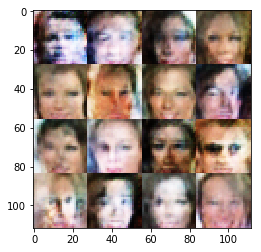

Epoch 1/1... Discriminator Loss: 1.2671... Generator Loss: 0.7008
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.4431
Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 0.4894
Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.4253
Epoch 1/1... Discriminator Loss: 1.2079... Generator Loss: 0.6365
Epoch 1/1... Discriminator Loss: 1.1461... Generator Loss: 0.6728
Epoch 1/1... Discriminator Loss: 1.2680... Generator Loss: 0.4436
Epoch 1/1... Discriminator Loss: 1.0647... Generator Loss: 0.7402
Epoch 1/1... Discriminator Loss: 1.4497... Generator Loss: 0.3386
Epoch 1/1... Discriminator Loss: 1.2634... Generator Loss: 0.5695


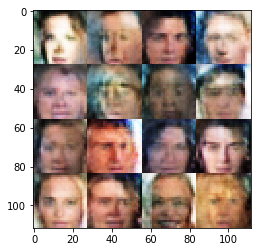

Epoch 1/1... Discriminator Loss: 1.0491... Generator Loss: 1.4894
Epoch 1/1... Discriminator Loss: 1.0594... Generator Loss: 0.9712
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 1.0596
Epoch 1/1... Discriminator Loss: 1.1617... Generator Loss: 0.5866
Epoch 1/1... Discriminator Loss: 1.0194... Generator Loss: 0.7543
Epoch 1/1... Discriminator Loss: 1.1538... Generator Loss: 0.5292
Epoch 1/1... Discriminator Loss: 1.0295... Generator Loss: 0.6905
Epoch 1/1... Discriminator Loss: 1.1660... Generator Loss: 0.6009
Epoch 1/1... Discriminator Loss: 1.7651... Generator Loss: 0.2535
Epoch 1/1... Discriminator Loss: 1.0392... Generator Loss: 0.6685


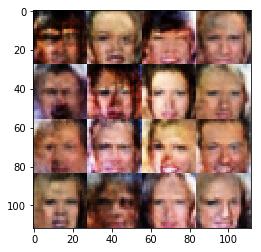

Epoch 1/1... Discriminator Loss: 0.7387... Generator Loss: 1.3831
Epoch 1/1... Discriminator Loss: 1.1902... Generator Loss: 0.5706
Epoch 1/1... Discriminator Loss: 1.0376... Generator Loss: 0.7812
Epoch 1/1... Discriminator Loss: 1.1632... Generator Loss: 0.5586
Epoch 1/1... Discriminator Loss: 1.3298... Generator Loss: 0.5530
Epoch 1/1... Discriminator Loss: 1.2199... Generator Loss: 0.8472
Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 0.4130
Epoch 1/1... Discriminator Loss: 0.9329... Generator Loss: 2.2996
Epoch 1/1... Discriminator Loss: 0.8189... Generator Loss: 0.8602
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.4444


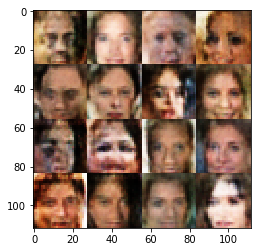

Epoch 1/1... Discriminator Loss: 1.3110... Generator Loss: 0.4502
Epoch 1/1... Discriminator Loss: 1.0430... Generator Loss: 0.8436
Epoch 1/1... Discriminator Loss: 1.2034... Generator Loss: 0.5786
Epoch 1/1... Discriminator Loss: 0.9245... Generator Loss: 1.0394
Epoch 1/1... Discriminator Loss: 1.1642... Generator Loss: 0.5277
Epoch 1/1... Discriminator Loss: 0.8535... Generator Loss: 0.8683
Epoch 1/1... Discriminator Loss: 1.1032... Generator Loss: 0.9348
Epoch 1/1... Discriminator Loss: 1.2419... Generator Loss: 0.8519
Epoch 1/1... Discriminator Loss: 0.9356... Generator Loss: 1.1808
Epoch 1/1... Discriminator Loss: 1.2884... Generator Loss: 0.5760


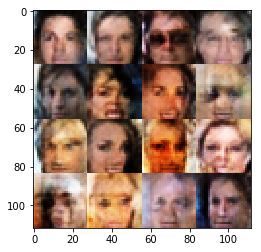

Epoch 1/1... Discriminator Loss: 1.2834... Generator Loss: 0.6776
Epoch 1/1... Discriminator Loss: 1.4839... Generator Loss: 0.4831
Epoch 1/1... Discriminator Loss: 1.0927... Generator Loss: 0.9451
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.4220
Epoch 1/1... Discriminator Loss: 1.1960... Generator Loss: 0.5319
Epoch 1/1... Discriminator Loss: 1.5645... Generator Loss: 0.4432
Epoch 1/1... Discriminator Loss: 1.1795... Generator Loss: 0.5787
Epoch 1/1... Discriminator Loss: 1.1533... Generator Loss: 0.7045
Epoch 1/1... Discriminator Loss: 1.2082... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 0.9505... Generator Loss: 0.9164


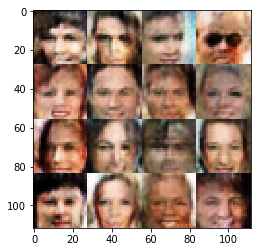

Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 0.5768
Epoch 1/1... Discriminator Loss: 1.1605... Generator Loss: 0.8312
Epoch 1/1... Discriminator Loss: 1.1528... Generator Loss: 1.0775
Epoch 1/1... Discriminator Loss: 1.1314... Generator Loss: 0.6650
Epoch 1/1... Discriminator Loss: 1.1637... Generator Loss: 0.6018
Epoch 1/1... Discriminator Loss: 1.0996... Generator Loss: 0.6175
Epoch 1/1... Discriminator Loss: 1.0593... Generator Loss: 0.8834
Epoch 1/1... Discriminator Loss: 1.2002... Generator Loss: 0.4896
Epoch 1/1... Discriminator Loss: 1.4894... Generator Loss: 0.3676
Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 0.5724


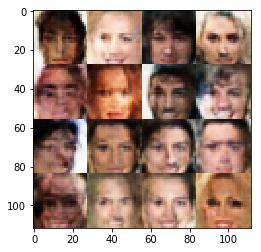

Epoch 1/1... Discriminator Loss: 1.1359... Generator Loss: 0.7212
Epoch 1/1... Discriminator Loss: 1.0321... Generator Loss: 0.7838
Epoch 1/1... Discriminator Loss: 1.3635... Generator Loss: 1.0940
Epoch 1/1... Discriminator Loss: 1.5519... Generator Loss: 0.3378
Epoch 1/1... Discriminator Loss: 1.1985... Generator Loss: 0.5487
Epoch 1/1... Discriminator Loss: 1.3246... Generator Loss: 0.4231
Epoch 1/1... Discriminator Loss: 1.1840... Generator Loss: 0.6333
Epoch 1/1... Discriminator Loss: 1.0327... Generator Loss: 0.6934
Epoch 1/1... Discriminator Loss: 1.1286... Generator Loss: 0.5728
Epoch 1/1... Discriminator Loss: 1.2342... Generator Loss: 0.7155


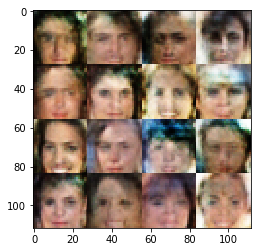

Epoch 1/1... Discriminator Loss: 0.9284... Generator Loss: 0.8248
Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 0.5198
Epoch 1/1... Discriminator Loss: 1.3654... Generator Loss: 0.4941
Epoch 1/1... Discriminator Loss: 1.9315... Generator Loss: 0.2018
Epoch 1/1... Discriminator Loss: 1.1746... Generator Loss: 0.6125
Epoch 1/1... Discriminator Loss: 1.6171... Generator Loss: 0.3074
Epoch 1/1... Discriminator Loss: 1.3529... Generator Loss: 0.4844
Epoch 1/1... Discriminator Loss: 1.2464... Generator Loss: 0.4866
Epoch 1/1... Discriminator Loss: 1.4741... Generator Loss: 0.3652
Epoch 1/1... Discriminator Loss: 0.8907... Generator Loss: 0.9282


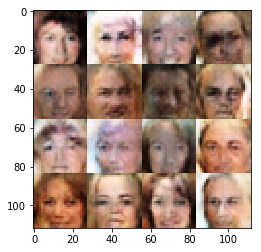

Epoch 1/1... Discriminator Loss: 0.9142... Generator Loss: 0.8878
Epoch 1/1... Discriminator Loss: 1.2750... Generator Loss: 0.4751
Epoch 1/1... Discriminator Loss: 1.1647... Generator Loss: 0.6691
Epoch 1/1... Discriminator Loss: 1.1566... Generator Loss: 0.5861
Epoch 1/1... Discriminator Loss: 1.1819... Generator Loss: 0.5516
Epoch 1/1... Discriminator Loss: 0.9569... Generator Loss: 0.8785
Epoch 1/1... Discriminator Loss: 1.2675... Generator Loss: 0.8297
Epoch 1/1... Discriminator Loss: 1.0456... Generator Loss: 0.8523
Epoch 1/1... Discriminator Loss: 1.1028... Generator Loss: 0.7378
Epoch 1/1... Discriminator Loss: 1.4764... Generator Loss: 0.3615


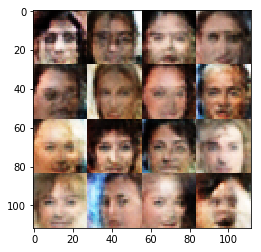

Epoch 1/1... Discriminator Loss: 1.5592... Generator Loss: 0.4350
Epoch 1/1... Discriminator Loss: 1.3324... Generator Loss: 0.4828
Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 0.4242
Epoch 1/1... Discriminator Loss: 1.2326... Generator Loss: 0.4723
Epoch 1/1... Discriminator Loss: 1.4435... Generator Loss: 0.4418
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.5028
Epoch 1/1... Discriminator Loss: 1.1891... Generator Loss: 0.4981
Epoch 1/1... Discriminator Loss: 1.1280... Generator Loss: 0.7061
Epoch 1/1... Discriminator Loss: 1.2308... Generator Loss: 0.5830
Epoch 1/1... Discriminator Loss: 1.2166... Generator Loss: 0.5246


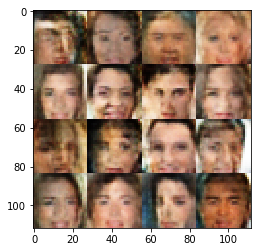

Epoch 1/1... Discriminator Loss: 1.5971... Generator Loss: 0.3121
Epoch 1/1... Discriminator Loss: 1.2543... Generator Loss: 0.5025
Epoch 1/1... Discriminator Loss: 1.4651... Generator Loss: 0.7858
Epoch 1/1... Discriminator Loss: 1.3600... Generator Loss: 0.4493
Epoch 1/1... Discriminator Loss: 1.2734... Generator Loss: 0.4516
Epoch 1/1... Discriminator Loss: 1.3400... Generator Loss: 0.5697
Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.5173
Epoch 1/1... Discriminator Loss: 1.2445... Generator Loss: 0.4967
Epoch 1/1... Discriminator Loss: 0.7973... Generator Loss: 0.8831
Epoch 1/1... Discriminator Loss: 0.9795... Generator Loss: 0.8695


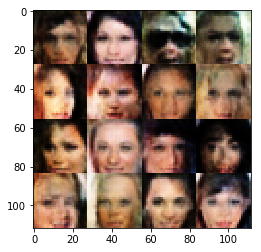

Epoch 1/1... Discriminator Loss: 1.2497... Generator Loss: 0.7883
Epoch 1/1... Discriminator Loss: 1.3362... Generator Loss: 1.1333
Epoch 1/1... Discriminator Loss: 1.7619... Generator Loss: 0.2348
Epoch 1/1... Discriminator Loss: 1.1248... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 1.3593... Generator Loss: 0.7097
Epoch 1/1... Discriminator Loss: 1.7589... Generator Loss: 0.3096
Epoch 1/1... Discriminator Loss: 1.1708... Generator Loss: 0.6366
Epoch 1/1... Discriminator Loss: 1.0061... Generator Loss: 1.1213
Epoch 1/1... Discriminator Loss: 1.7151... Generator Loss: 0.2672
Epoch 1/1... Discriminator Loss: 1.0566... Generator Loss: 0.9884


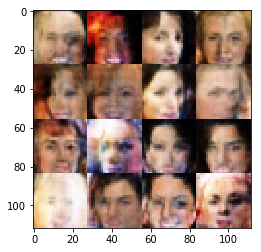

Epoch 1/1... Discriminator Loss: 1.1805... Generator Loss: 0.6909
Epoch 1/1... Discriminator Loss: 1.2108... Generator Loss: 0.5600
Epoch 1/1... Discriminator Loss: 1.3404... Generator Loss: 0.5546
Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.8439
Epoch 1/1... Discriminator Loss: 1.2435... Generator Loss: 0.7371
Epoch 1/1... Discriminator Loss: 1.1149... Generator Loss: 0.6408
Epoch 1/1... Discriminator Loss: 1.7686... Generator Loss: 0.7732
Epoch 1/1... Discriminator Loss: 1.4677... Generator Loss: 0.3638
Epoch 1/1... Discriminator Loss: 1.2701... Generator Loss: 0.6338
Epoch 1/1... Discriminator Loss: 0.9693... Generator Loss: 0.8959


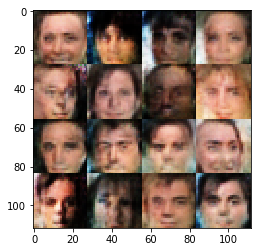

Epoch 1/1... Discriminator Loss: 1.0551... Generator Loss: 1.0854
Epoch 1/1... Discriminator Loss: 1.1453... Generator Loss: 0.6620
Epoch 1/1... Discriminator Loss: 1.0415... Generator Loss: 0.6207
Epoch 1/1... Discriminator Loss: 1.2730... Generator Loss: 0.6046
Epoch 1/1... Discriminator Loss: 1.3464... Generator Loss: 0.5784
Epoch 1/1... Discriminator Loss: 0.9279... Generator Loss: 0.9487
Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 0.5769
Epoch 1/1... Discriminator Loss: 1.4864... Generator Loss: 0.3561
Epoch 1/1... Discriminator Loss: 0.9419... Generator Loss: 0.8074
Epoch 1/1... Discriminator Loss: 1.0207... Generator Loss: 0.7340


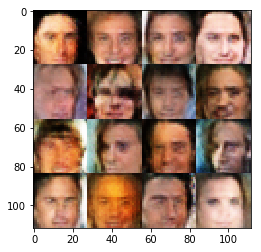

Epoch 1/1... Discriminator Loss: 1.5952... Generator Loss: 0.2859
Epoch 1/1... Discriminator Loss: 1.2407... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 1.2174... Generator Loss: 0.5059
Epoch 1/1... Discriminator Loss: 1.2707... Generator Loss: 0.5010
Epoch 1/1... Discriminator Loss: 1.3110... Generator Loss: 0.7144
Epoch 1/1... Discriminator Loss: 1.0680... Generator Loss: 0.9139
Epoch 1/1... Discriminator Loss: 1.3085... Generator Loss: 0.6171
Epoch 1/1... Discriminator Loss: 1.2200... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.7480... Generator Loss: 0.2816
Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 0.3942


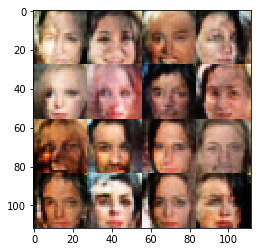

Epoch 1/1... Discriminator Loss: 1.2529... Generator Loss: 0.6492
Epoch 1/1... Discriminator Loss: 1.0589... Generator Loss: 0.7834
Epoch 1/1... Discriminator Loss: 1.2906... Generator Loss: 0.5671
Epoch 1/1... Discriminator Loss: 0.9562... Generator Loss: 1.0217
Epoch 1/1... Discriminator Loss: 1.3113... Generator Loss: 0.4782
Epoch 1/1... Discriminator Loss: 1.5607... Generator Loss: 0.2727
Epoch 1/1... Discriminator Loss: 1.2675... Generator Loss: 0.8875
Epoch 1/1... Discriminator Loss: 1.1339... Generator Loss: 0.5928
Epoch 1/1... Discriminator Loss: 1.0467... Generator Loss: 0.8020
Epoch 1/1... Discriminator Loss: 1.0507... Generator Loss: 0.6233


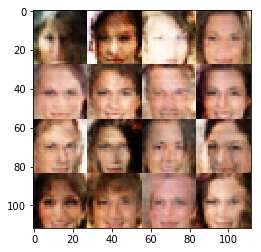

Epoch 1/1... Discriminator Loss: 0.9809... Generator Loss: 0.7556
Epoch 1/1... Discriminator Loss: 1.0908... Generator Loss: 0.6087
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.4425
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.3859
Epoch 1/1... Discriminator Loss: 2.1982... Generator Loss: 0.1555
Epoch 1/1... Discriminator Loss: 1.2621... Generator Loss: 0.5446
Epoch 1/1... Discriminator Loss: 1.4927... Generator Loss: 0.4094
Epoch 1/1... Discriminator Loss: 1.3343... Generator Loss: 0.4943
Epoch 1/1... Discriminator Loss: 0.9204... Generator Loss: 0.9610
Epoch 1/1... Discriminator Loss: 0.7554... Generator Loss: 0.9858


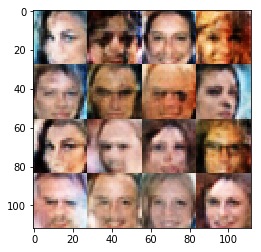

Epoch 1/1... Discriminator Loss: 1.4656... Generator Loss: 0.4538
Epoch 1/1... Discriminator Loss: 1.1602... Generator Loss: 0.5240
Epoch 1/1... Discriminator Loss: 1.4501... Generator Loss: 0.3740
Epoch 1/1... Discriminator Loss: 1.3183... Generator Loss: 0.5196
Epoch 1/1... Discriminator Loss: 1.1015... Generator Loss: 0.6634
Epoch 1/1... Discriminator Loss: 0.9256... Generator Loss: 0.9133
Epoch 1/1... Discriminator Loss: 1.2777... Generator Loss: 0.7029
Epoch 1/1... Discriminator Loss: 1.0748... Generator Loss: 0.8043
Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 0.5617
Epoch 1/1... Discriminator Loss: 1.0056... Generator Loss: 0.7738


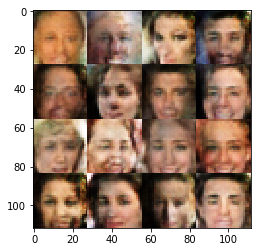

Epoch 1/1... Discriminator Loss: 1.3178... Generator Loss: 0.5485
Epoch 1/1... Discriminator Loss: 0.9621... Generator Loss: 0.7106
Epoch 1/1... Discriminator Loss: 1.1665... Generator Loss: 0.6028
Epoch 1/1... Discriminator Loss: 1.4380... Generator Loss: 0.4815
Epoch 1/1... Discriminator Loss: 0.9309... Generator Loss: 0.7349
Epoch 1/1... Discriminator Loss: 1.2097... Generator Loss: 0.8717
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.4071
Epoch 1/1... Discriminator Loss: 1.7091... Generator Loss: 0.2534
Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 0.4697
Epoch 1/1... Discriminator Loss: 1.3261... Generator Loss: 0.5356


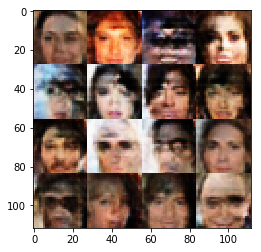

Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 0.4086
Epoch 1/1... Discriminator Loss: 1.0746... Generator Loss: 0.5929
Epoch 1/1... Discriminator Loss: 0.9866... Generator Loss: 0.8334
Epoch 1/1... Discriminator Loss: 1.5493... Generator Loss: 0.3365
Epoch 1/1... Discriminator Loss: 1.5964... Generator Loss: 0.3165
Epoch 1/1... Discriminator Loss: 1.0260... Generator Loss: 0.7134
Epoch 1/1... Discriminator Loss: 1.2180... Generator Loss: 0.4694
Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.3967
Epoch 1/1... Discriminator Loss: 1.5323... Generator Loss: 0.3715
Epoch 1/1... Discriminator Loss: 1.2669... Generator Loss: 0.5438


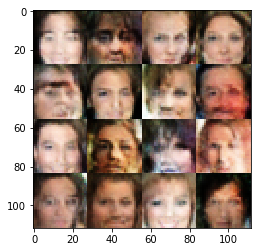

Epoch 1/1... Discriminator Loss: 1.0429... Generator Loss: 0.9933
Epoch 1/1... Discriminator Loss: 1.6596... Generator Loss: 0.2813
Epoch 1/1... Discriminator Loss: 1.7578... Generator Loss: 0.3248
Epoch 1/1... Discriminator Loss: 0.6319... Generator Loss: 1.2613
Epoch 1/1... Discriminator Loss: 1.4748... Generator Loss: 0.3636
Epoch 1/1... Discriminator Loss: 1.1613... Generator Loss: 0.6662
Epoch 1/1... Discriminator Loss: 1.0335... Generator Loss: 0.9498
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.4042
Epoch 1/1... Discriminator Loss: 1.6524... Generator Loss: 0.4064
Epoch 1/1... Discriminator Loss: 1.2447... Generator Loss: 0.5580


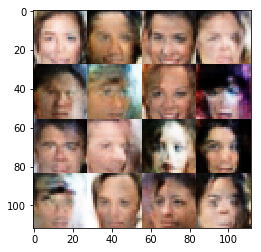

Epoch 1/1... Discriminator Loss: 1.0480... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 1.2349... Generator Loss: 0.4636
Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.4312
Epoch 1/1... Discriminator Loss: 1.1980... Generator Loss: 0.4814
Epoch 1/1... Discriminator Loss: 1.6601... Generator Loss: 0.2617
Epoch 1/1... Discriminator Loss: 1.1091... Generator Loss: 1.1608
Epoch 1/1... Discriminator Loss: 0.9237... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 1.2685... Generator Loss: 0.5356
Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.4919
Epoch 1/1... Discriminator Loss: 1.3234... Generator Loss: 0.4804


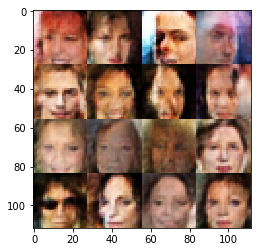

Epoch 1/1... Discriminator Loss: 1.2748... Generator Loss: 0.4101
Epoch 1/1... Discriminator Loss: 1.0487... Generator Loss: 0.7479
Epoch 1/1... Discriminator Loss: 1.3451... Generator Loss: 0.4349
Epoch 1/1... Discriminator Loss: 1.0799... Generator Loss: 0.6439
Epoch 1/1... Discriminator Loss: 1.2038... Generator Loss: 0.5167
Epoch 1/1... Discriminator Loss: 1.6949... Generator Loss: 0.2561
Epoch 1/1... Discriminator Loss: 1.0199... Generator Loss: 0.7583
Epoch 1/1... Discriminator Loss: 0.9004... Generator Loss: 0.9334
Epoch 1/1... Discriminator Loss: 1.0497... Generator Loss: 1.0245
Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 0.4197


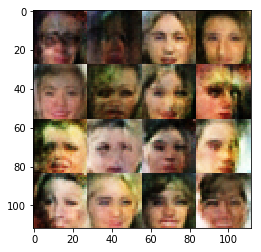

Epoch 1/1... Discriminator Loss: 1.2258... Generator Loss: 0.5391
Epoch 1/1... Discriminator Loss: 1.1803... Generator Loss: 0.5780
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.5033
Epoch 1/1... Discriminator Loss: 1.1732... Generator Loss: 0.9763
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.5669
Epoch 1/1... Discriminator Loss: 1.0354... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.4554... Generator Loss: 0.3543
Epoch 1/1... Discriminator Loss: 1.3350... Generator Loss: 0.6933
Epoch 1/1... Discriminator Loss: 1.2108... Generator Loss: 0.5004
Epoch 1/1... Discriminator Loss: 1.1006... Generator Loss: 0.6394


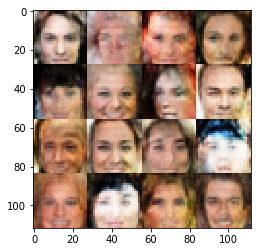

Epoch 1/1... Discriminator Loss: 0.8944... Generator Loss: 1.1427
Epoch 1/1... Discriminator Loss: 1.2489... Generator Loss: 0.5926
Epoch 1/1... Discriminator Loss: 1.5191... Generator Loss: 0.3102
Epoch 1/1... Discriminator Loss: 1.2491... Generator Loss: 0.7421
Epoch 1/1... Discriminator Loss: 1.1147... Generator Loss: 0.7662
Epoch 1/1... Discriminator Loss: 1.2648... Generator Loss: 0.4834
Epoch 1/1... Discriminator Loss: 0.9380... Generator Loss: 0.7976
Epoch 1/1... Discriminator Loss: 1.4378... Generator Loss: 0.3955
Epoch 1/1... Discriminator Loss: 1.5932... Generator Loss: 0.3548
Epoch 1/1... Discriminator Loss: 1.5057... Generator Loss: 0.4483


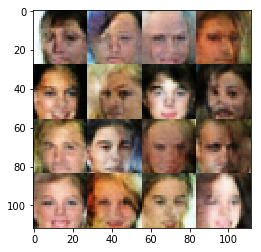

Epoch 1/1... Discriminator Loss: 1.2066... Generator Loss: 0.5191
Epoch 1/1... Discriminator Loss: 1.6967... Generator Loss: 0.2578
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.4358
Epoch 1/1... Discriminator Loss: 1.1447... Generator Loss: 0.5922
Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.4415
Epoch 1/1... Discriminator Loss: 1.5804... Generator Loss: 0.3646
Epoch 1/1... Discriminator Loss: 1.6430... Generator Loss: 0.3006
Epoch 1/1... Discriminator Loss: 1.0691... Generator Loss: 1.0263
Epoch 1/1... Discriminator Loss: 1.1172... Generator Loss: 0.6606
Epoch 1/1... Discriminator Loss: 1.0725... Generator Loss: 0.7984


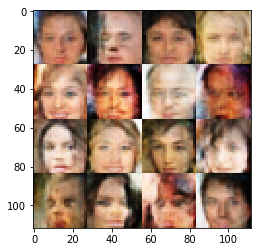

Epoch 1/1... Discriminator Loss: 1.1735... Generator Loss: 0.7340
Epoch 1/1... Discriminator Loss: 1.3081... Generator Loss: 0.6707
Epoch 1/1... Discriminator Loss: 1.4518... Generator Loss: 0.4479
Epoch 1/1... Discriminator Loss: 1.1961... Generator Loss: 0.6318
Epoch 1/1... Discriminator Loss: 1.3009... Generator Loss: 0.4959
Epoch 1/1... Discriminator Loss: 1.2052... Generator Loss: 0.5551
Epoch 1/1... Discriminator Loss: 1.4526... Generator Loss: 0.4229
Epoch 1/1... Discriminator Loss: 1.2128... Generator Loss: 0.9814
Epoch 1/1... Discriminator Loss: 1.1063... Generator Loss: 0.8831
Epoch 1/1... Discriminator Loss: 1.3358... Generator Loss: 0.4468


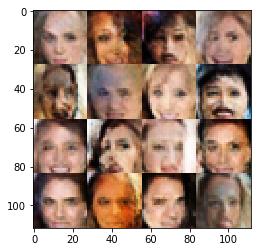

Epoch 1/1... Discriminator Loss: 1.1825... Generator Loss: 0.5563
Epoch 1/1... Discriminator Loss: 1.2086... Generator Loss: 0.5774
Epoch 1/1... Discriminator Loss: 1.2730... Generator Loss: 0.6190
Epoch 1/1... Discriminator Loss: 1.1517... Generator Loss: 0.6505
Epoch 1/1... Discriminator Loss: 1.5193... Generator Loss: 0.4144
Epoch 1/1... Discriminator Loss: 1.2910... Generator Loss: 0.5685
Epoch 1/1... Discriminator Loss: 1.9037... Generator Loss: 0.2030
Epoch 1/1... Discriminator Loss: 1.3024... Generator Loss: 0.7625
Epoch 1/1... Discriminator Loss: 1.4734... Generator Loss: 0.3900
Epoch 1/1... Discriminator Loss: 1.3027... Generator Loss: 0.5545


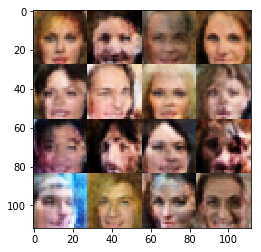

Epoch 1/1... Discriminator Loss: 1.3115... Generator Loss: 0.5124
Epoch 1/1... Discriminator Loss: 1.1635... Generator Loss: 0.6201
Epoch 1/1... Discriminator Loss: 1.0976... Generator Loss: 0.8533
Epoch 1/1... Discriminator Loss: 1.0130... Generator Loss: 1.1241
Epoch 1/1... Discriminator Loss: 1.3458... Generator Loss: 0.3971
Epoch 1/1... Discriminator Loss: 1.6707... Generator Loss: 0.2878
Epoch 1/1... Discriminator Loss: 1.7813... Generator Loss: 0.2807
Epoch 1/1... Discriminator Loss: 1.1576... Generator Loss: 0.6464
Epoch 1/1... Discriminator Loss: 1.2978... Generator Loss: 0.4824
Epoch 1/1... Discriminator Loss: 1.0550... Generator Loss: 0.7591


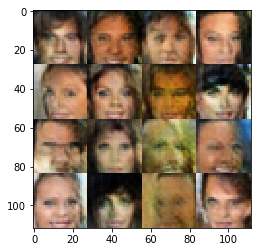

Epoch 1/1... Discriminator Loss: 1.0187... Generator Loss: 0.6649
Epoch 1/1... Discriminator Loss: 1.0664... Generator Loss: 0.8243
Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.5651
Epoch 1/1... Discriminator Loss: 1.1958... Generator Loss: 0.5225
Epoch 1/1... Discriminator Loss: 1.1183... Generator Loss: 0.5445
Epoch 1/1... Discriminator Loss: 1.0467... Generator Loss: 0.8409
Epoch 1/1... Discriminator Loss: 1.2585... Generator Loss: 0.5588
Epoch 1/1... Discriminator Loss: 1.1032... Generator Loss: 0.6878
Epoch 1/1... Discriminator Loss: 1.0775... Generator Loss: 0.7243
Epoch 1/1... Discriminator Loss: 1.0270... Generator Loss: 0.6730


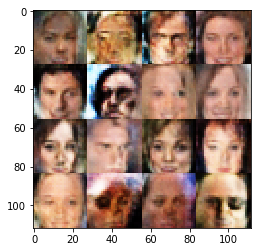

Epoch 1/1... Discriminator Loss: 1.6568... Generator Loss: 0.2464
Epoch 1/1... Discriminator Loss: 1.3119... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 0.9940... Generator Loss: 0.7623
Epoch 1/1... Discriminator Loss: 1.5125... Generator Loss: 0.7663
Epoch 1/1... Discriminator Loss: 0.9752... Generator Loss: 0.8064
Epoch 1/1... Discriminator Loss: 1.2657... Generator Loss: 0.5488
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 0.4969
Epoch 1/1... Discriminator Loss: 1.5157... Generator Loss: 0.3770
Epoch 1/1... Discriminator Loss: 1.2668... Generator Loss: 0.5823
Epoch 1/1... Discriminator Loss: 1.2688... Generator Loss: 0.5140


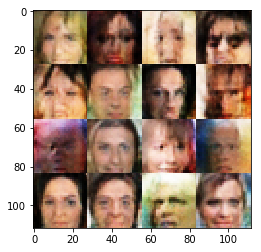

Epoch 1/1... Discriminator Loss: 0.8172... Generator Loss: 1.2344
Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.5727
Epoch 1/1... Discriminator Loss: 1.5272... Generator Loss: 0.3717
Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.3453
Epoch 1/1... Discriminator Loss: 1.2641... Generator Loss: 0.5120
Epoch 1/1... Discriminator Loss: 1.0511... Generator Loss: 0.6451
Epoch 1/1... Discriminator Loss: 1.5900... Generator Loss: 0.3988
Epoch 1/1... Discriminator Loss: 1.3096... Generator Loss: 0.5669
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.5153
Epoch 1/1... Discriminator Loss: 1.2720... Generator Loss: 0.5558


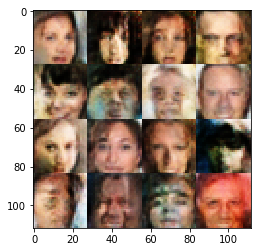

Epoch 1/1... Discriminator Loss: 1.2087... Generator Loss: 0.5747
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.4515
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.5106
Epoch 1/1... Discriminator Loss: 1.5408... Generator Loss: 0.3283
Epoch 1/1... Discriminator Loss: 0.8782... Generator Loss: 0.8621
Epoch 1/1... Discriminator Loss: 1.4601... Generator Loss: 0.4081
Epoch 1/1... Discriminator Loss: 1.2107... Generator Loss: 0.5672
Epoch 1/1... Discriminator Loss: 1.0764... Generator Loss: 0.7874
Epoch 1/1... Discriminator Loss: 0.9913... Generator Loss: 0.7728
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.7257


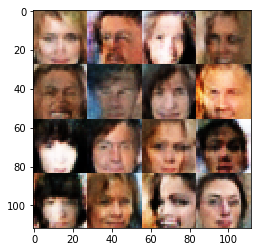

Epoch 1/1... Discriminator Loss: 1.1251... Generator Loss: 0.9351
Epoch 1/1... Discriminator Loss: 1.1166... Generator Loss: 0.8568
Epoch 1/1... Discriminator Loss: 0.9502... Generator Loss: 1.0398
Epoch 1/1... Discriminator Loss: 1.2236... Generator Loss: 0.5249
Epoch 1/1... Discriminator Loss: 1.2052... Generator Loss: 0.6215
Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 0.6527
Epoch 1/1... Discriminator Loss: 1.2109... Generator Loss: 0.6703
Epoch 1/1... Discriminator Loss: 1.1976... Generator Loss: 0.5135
Epoch 1/1... Discriminator Loss: 1.1698... Generator Loss: 0.5408
Epoch 1/1... Discriminator Loss: 1.2748... Generator Loss: 0.7571


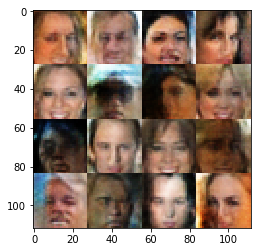

Epoch 1/1... Discriminator Loss: 1.1029... Generator Loss: 0.7461
Epoch 1/1... Discriminator Loss: 1.2704... Generator Loss: 0.5305
Epoch 1/1... Discriminator Loss: 1.4441... Generator Loss: 0.5668
Epoch 1/1... Discriminator Loss: 1.4170... Generator Loss: 0.4214
Epoch 1/1... Discriminator Loss: 1.2827... Generator Loss: 0.5637
Epoch 1/1... Discriminator Loss: 1.2742... Generator Loss: 0.5139
Epoch 1/1... Discriminator Loss: 0.9272... Generator Loss: 0.9271
Epoch 1/1... Discriminator Loss: 1.3544... Generator Loss: 0.7506
Epoch 1/1... Discriminator Loss: 1.0752... Generator Loss: 0.8188
Epoch 1/1... Discriminator Loss: 0.9575... Generator Loss: 0.8106


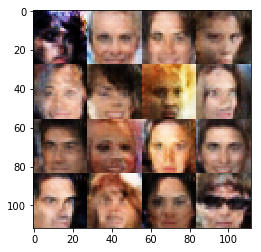

Epoch 1/1... Discriminator Loss: 1.2669... Generator Loss: 0.5406
Epoch 1/1... Discriminator Loss: 1.0983... Generator Loss: 0.5690
Epoch 1/1... Discriminator Loss: 0.8687... Generator Loss: 0.8364
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.3942
Epoch 1/1... Discriminator Loss: 1.0965... Generator Loss: 0.8152
Epoch 1/1... Discriminator Loss: 1.1459... Generator Loss: 0.5950
Epoch 1/1... Discriminator Loss: 1.2570... Generator Loss: 0.5095
Epoch 1/1... Discriminator Loss: 1.3295... Generator Loss: 0.4492
Epoch 1/1... Discriminator Loss: 1.1341... Generator Loss: 0.7519
Epoch 1/1... Discriminator Loss: 1.2995... Generator Loss: 0.5181


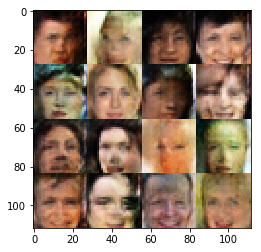

Epoch 1/1... Discriminator Loss: 0.9972... Generator Loss: 0.9676
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.4107
Epoch 1/1... Discriminator Loss: 1.2466... Generator Loss: 0.6980
Epoch 1/1... Discriminator Loss: 1.1990... Generator Loss: 0.5504
Epoch 1/1... Discriminator Loss: 1.1868... Generator Loss: 0.5979
Epoch 1/1... Discriminator Loss: 1.2493... Generator Loss: 1.3251
Epoch 1/1... Discriminator Loss: 2.2236... Generator Loss: 0.1642
Epoch 1/1... Discriminator Loss: 1.4668... Generator Loss: 0.3481
Epoch 1/1... Discriminator Loss: 1.2746... Generator Loss: 0.4859
Epoch 1/1... Discriminator Loss: 1.2803... Generator Loss: 0.5227


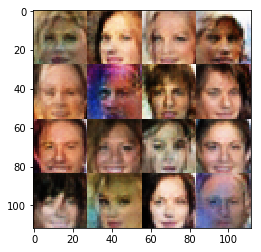

Epoch 1/1... Discriminator Loss: 1.2421... Generator Loss: 0.5774
Epoch 1/1... Discriminator Loss: 0.9871... Generator Loss: 0.9444
Epoch 1/1... Discriminator Loss: 1.4644... Generator Loss: 0.4042
Epoch 1/1... Discriminator Loss: 1.0637... Generator Loss: 0.8027
Epoch 1/1... Discriminator Loss: 0.9665... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 1.2342... Generator Loss: 0.5171
Epoch 1/1... Discriminator Loss: 1.2757... Generator Loss: 0.6065
Epoch 1/1... Discriminator Loss: 1.0508... Generator Loss: 0.8206
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.4722
Epoch 1/1... Discriminator Loss: 1.2366... Generator Loss: 0.5973


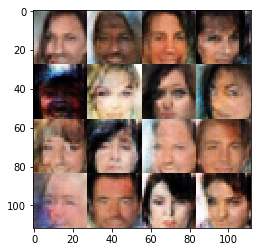

Epoch 1/1... Discriminator Loss: 1.0688... Generator Loss: 0.8185
Epoch 1/1... Discriminator Loss: 1.2436... Generator Loss: 0.6621
Epoch 1/1... Discriminator Loss: 1.1987... Generator Loss: 0.5548
Epoch 1/1... Discriminator Loss: 0.7961... Generator Loss: 0.9679
Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.3627
Epoch 1/1... Discriminator Loss: 1.2181... Generator Loss: 0.5133
Epoch 1/1... Discriminator Loss: 1.4598... Generator Loss: 0.3690
Epoch 1/1... Discriminator Loss: 1.7118... Generator Loss: 0.2454
Epoch 1/1... Discriminator Loss: 1.2804... Generator Loss: 0.6349
Epoch 1/1... Discriminator Loss: 1.5021... Generator Loss: 0.7735


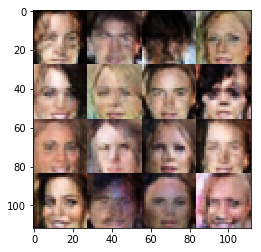

Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 0.4327
Epoch 1/1... Discriminator Loss: 1.2353... Generator Loss: 0.7310
Epoch 1/1... Discriminator Loss: 1.2470... Generator Loss: 0.5819
Epoch 1/1... Discriminator Loss: 1.1125... Generator Loss: 0.7371
Epoch 1/1... Discriminator Loss: 1.2332... Generator Loss: 0.5959
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.4066
Epoch 1/1... Discriminator Loss: 1.3497... Generator Loss: 0.5474
Epoch 1/1... Discriminator Loss: 1.2350... Generator Loss: 1.0975
Epoch 1/1... Discriminator Loss: 1.3134... Generator Loss: 0.5108
Epoch 1/1... Discriminator Loss: 1.2760... Generator Loss: 0.7218


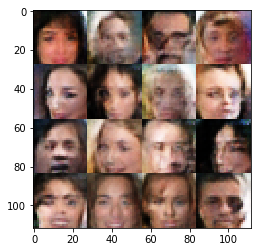

Epoch 1/1... Discriminator Loss: 1.4683... Generator Loss: 0.5590
Epoch 1/1... Discriminator Loss: 1.1136... Generator Loss: 0.6441
Epoch 1/1... Discriminator Loss: 1.2819... Generator Loss: 0.7576
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.4392
Epoch 1/1... Discriminator Loss: 1.1179... Generator Loss: 0.5873
Epoch 1/1... Discriminator Loss: 1.4569... Generator Loss: 0.5350
Epoch 1/1... Discriminator Loss: 1.2927... Generator Loss: 0.4927
Epoch 1/1... Discriminator Loss: 1.3328... Generator Loss: 0.6266
Epoch 1/1... Discriminator Loss: 1.1032... Generator Loss: 0.6402
Epoch 1/1... Discriminator Loss: 1.5162... Generator Loss: 0.3437


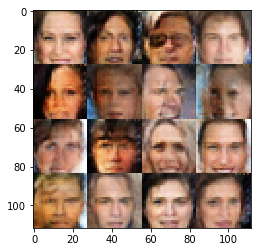

Epoch 1/1... Discriminator Loss: 1.1393... Generator Loss: 0.7310
Epoch 1/1... Discriminator Loss: 1.2212... Generator Loss: 0.5238
Epoch 1/1... Discriminator Loss: 1.3602... Generator Loss: 0.4793
Epoch 1/1... Discriminator Loss: 1.0026... Generator Loss: 0.8448
Epoch 1/1... Discriminator Loss: 1.1018... Generator Loss: 0.6771
Epoch 1/1... Discriminator Loss: 1.1339... Generator Loss: 0.7827
Epoch 1/1... Discriminator Loss: 1.2986... Generator Loss: 0.4339
Epoch 1/1... Discriminator Loss: 1.1494... Generator Loss: 0.6283
Epoch 1/1... Discriminator Loss: 1.1336... Generator Loss: 0.7011
Epoch 1/1... Discriminator Loss: 1.0537... Generator Loss: 0.6884


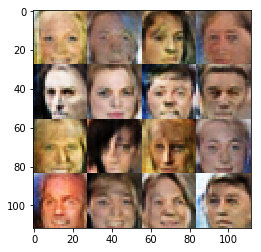

Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.4074
Epoch 1/1... Discriminator Loss: 1.5732... Generator Loss: 0.4187
Epoch 1/1... Discriminator Loss: 0.9396... Generator Loss: 0.8019
Epoch 1/1... Discriminator Loss: 1.3355... Generator Loss: 0.5637
Epoch 1/1... Discriminator Loss: 1.0005... Generator Loss: 0.9351
Epoch 1/1... Discriminator Loss: 1.6782... Generator Loss: 0.2862
Epoch 1/1... Discriminator Loss: 1.8348... Generator Loss: 0.2430
Epoch 1/1... Discriminator Loss: 1.0805... Generator Loss: 0.9190
Epoch 1/1... Discriminator Loss: 1.3394... Generator Loss: 0.4542
Epoch 1/1... Discriminator Loss: 1.2874... Generator Loss: 0.5590


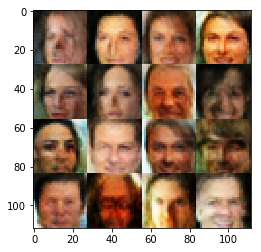

Epoch 1/1... Discriminator Loss: 1.0770... Generator Loss: 0.6631
Epoch 1/1... Discriminator Loss: 0.9575... Generator Loss: 0.7856
Epoch 1/1... Discriminator Loss: 1.2450... Generator Loss: 0.6638
Epoch 1/1... Discriminator Loss: 0.9794... Generator Loss: 0.6643
Epoch 1/1... Discriminator Loss: 1.5578... Generator Loss: 0.3865
Epoch 1/1... Discriminator Loss: 1.1397... Generator Loss: 0.6394
Epoch 1/1... Discriminator Loss: 1.1363... Generator Loss: 0.6627
Epoch 1/1... Discriminator Loss: 1.1005... Generator Loss: 0.5800
Epoch 1/1... Discriminator Loss: 1.0840... Generator Loss: 0.5794
Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.3993


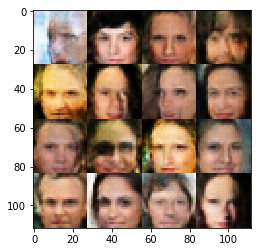

Epoch 1/1... Discriminator Loss: 1.3644... Generator Loss: 0.6315
Epoch 1/1... Discriminator Loss: 1.0520... Generator Loss: 0.6432
Epoch 1/1... Discriminator Loss: 1.1431... Generator Loss: 0.9476
Epoch 1/1... Discriminator Loss: 1.1805... Generator Loss: 0.6030
Epoch 1/1... Discriminator Loss: 1.3285... Generator Loss: 0.4153
Epoch 1/1... Discriminator Loss: 1.1521... Generator Loss: 0.5935
Epoch 1/1... Discriminator Loss: 1.3048... Generator Loss: 0.6304
Epoch 1/1... Discriminator Loss: 1.3392... Generator Loss: 0.4695
Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 0.4586
Epoch 1/1... Discriminator Loss: 1.0760... Generator Loss: 0.8137


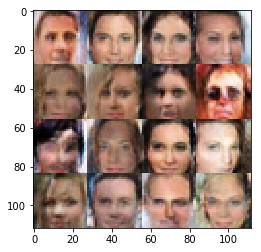

Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.4181
Epoch 1/1... Discriminator Loss: 1.2394... Generator Loss: 0.5831
Epoch 1/1... Discriminator Loss: 1.0599... Generator Loss: 0.8443
Epoch 1/1... Discriminator Loss: 1.4581... Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 1.1037... Generator Loss: 0.7989
Epoch 1/1... Discriminator Loss: 1.0805... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 1.5112... Generator Loss: 0.3843
Epoch 1/1... Discriminator Loss: 1.2903... Generator Loss: 0.4648
Epoch 1/1... Discriminator Loss: 1.1606... Generator Loss: 0.6061
Epoch 1/1... Discriminator Loss: 1.5490... Generator Loss: 0.4974


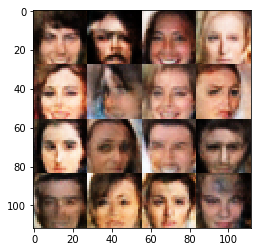

Epoch 1/1... Discriminator Loss: 0.9804... Generator Loss: 0.7013
Epoch 1/1... Discriminator Loss: 1.5722... Generator Loss: 0.3472
Epoch 1/1... Discriminator Loss: 1.5495... Generator Loss: 0.3324
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.4356
Epoch 1/1... Discriminator Loss: 1.3369... Generator Loss: 0.4644
Epoch 1/1... Discriminator Loss: 1.3390... Generator Loss: 0.5488
Epoch 1/1... Discriminator Loss: 1.2906... Generator Loss: 0.8477
Epoch 1/1... Discriminator Loss: 1.2111... Generator Loss: 0.5373
Epoch 1/1... Discriminator Loss: 1.1948... Generator Loss: 0.8235
Epoch 1/1... Discriminator Loss: 1.2797... Generator Loss: 0.4493


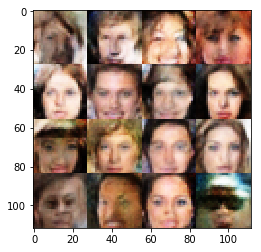

Epoch 1/1... Discriminator Loss: 1.3292... Generator Loss: 0.5038
Epoch 1/1... Discriminator Loss: 1.4717... Generator Loss: 0.4723
Epoch 1/1... Discriminator Loss: 1.5352... Generator Loss: 0.8003
Epoch 1/1... Discriminator Loss: 1.1327... Generator Loss: 0.8310
Epoch 1/1... Discriminator Loss: 1.1919... Generator Loss: 0.5345
Epoch 1/1... Discriminator Loss: 1.2135... Generator Loss: 0.5674
Epoch 1/1... Discriminator Loss: 1.0225... Generator Loss: 0.6569
Epoch 1/1... Discriminator Loss: 1.3139... Generator Loss: 0.4221
Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 0.3878
Epoch 1/1... Discriminator Loss: 1.3251... Generator Loss: 0.5439


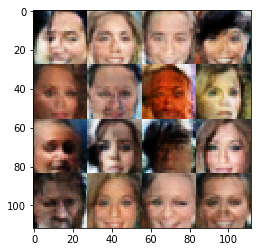

Epoch 1/1... Discriminator Loss: 1.2258... Generator Loss: 1.0090
Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.5768
Epoch 1/1... Discriminator Loss: 1.1229... Generator Loss: 0.5824
Epoch 1/1... Discriminator Loss: 1.1476... Generator Loss: 0.6127
Epoch 1/1... Discriminator Loss: 1.2161... Generator Loss: 0.5940
Epoch 1/1... Discriminator Loss: 1.1169... Generator Loss: 0.6791
Epoch 1/1... Discriminator Loss: 1.1827... Generator Loss: 0.6245
Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 0.5432
Epoch 1/1... Discriminator Loss: 1.2409... Generator Loss: 0.5172
Epoch 1/1... Discriminator Loss: 1.0399... Generator Loss: 0.6760


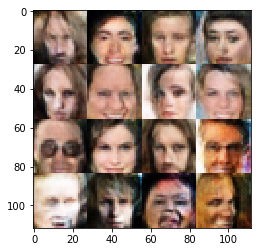

Epoch 1/1... Discriminator Loss: 1.4520... Generator Loss: 0.5016
Epoch 1/1... Discriminator Loss: 1.1891... Generator Loss: 0.7315
Epoch 1/1... Discriminator Loss: 1.2260... Generator Loss: 0.5406
Epoch 1/1... Discriminator Loss: 1.1101... Generator Loss: 0.6941
Epoch 1/1... Discriminator Loss: 1.0099... Generator Loss: 0.6678
Epoch 1/1... Discriminator Loss: 1.2357... Generator Loss: 0.5322
Epoch 1/1... Discriminator Loss: 1.2802... Generator Loss: 0.5282
Epoch 1/1... Discriminator Loss: 1.8820... Generator Loss: 0.8216
Epoch 1/1... Discriminator Loss: 1.5333... Generator Loss: 0.3728
Epoch 1/1... Discriminator Loss: 1.0232... Generator Loss: 0.6026


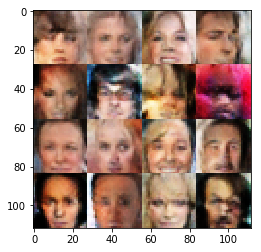

Epoch 1/1... Discriminator Loss: 1.2395... Generator Loss: 0.6387
Epoch 1/1... Discriminator Loss: 1.0865... Generator Loss: 0.5876
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.5302
Epoch 1/1... Discriminator Loss: 1.2224... Generator Loss: 0.5429
Epoch 1/1... Discriminator Loss: 1.5220... Generator Loss: 0.4027
Epoch 1/1... Discriminator Loss: 1.1411... Generator Loss: 0.7505
Epoch 1/1... Discriminator Loss: 1.0702... Generator Loss: 0.6035
Epoch 1/1... Discriminator Loss: 1.0463... Generator Loss: 1.0309
Epoch 1/1... Discriminator Loss: 1.6438... Generator Loss: 0.3154
Epoch 1/1... Discriminator Loss: 1.1331... Generator Loss: 0.5258


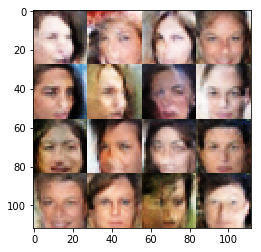

Epoch 1/1... Discriminator Loss: 0.9956... Generator Loss: 0.8723
Epoch 1/1... Discriminator Loss: 1.5962... Generator Loss: 0.3293
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.5216
Epoch 1/1... Discriminator Loss: 1.0742... Generator Loss: 0.7334
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.4218
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.5067
Epoch 1/1... Discriminator Loss: 1.2915... Generator Loss: 0.5498
Epoch 1/1... Discriminator Loss: 0.9245... Generator Loss: 0.8629
Epoch 1/1... Discriminator Loss: 1.5366... Generator Loss: 0.3860
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.4928


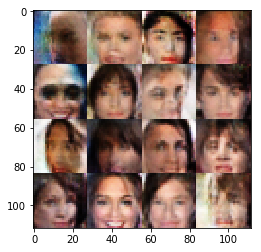

Epoch 1/1... Discriminator Loss: 1.2695... Generator Loss: 0.5770
Epoch 1/1... Discriminator Loss: 1.2868... Generator Loss: 0.5607
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.4806
Epoch 1/1... Discriminator Loss: 1.2918... Generator Loss: 0.5533
Epoch 1/1... Discriminator Loss: 1.1159... Generator Loss: 0.8260
Epoch 1/1... Discriminator Loss: 1.2422... Generator Loss: 0.6649
Epoch 1/1... Discriminator Loss: 1.3241... Generator Loss: 0.3948
Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 0.6387
Epoch 1/1... Discriminator Loss: 1.5859... Generator Loss: 0.3279
Epoch 1/1... Discriminator Loss: 1.3123... Generator Loss: 0.5058


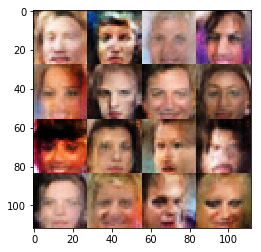

Epoch 1/1... Discriminator Loss: 1.1899... Generator Loss: 0.6793
Epoch 1/1... Discriminator Loss: 1.4725... Generator Loss: 0.4426
Epoch 1/1... Discriminator Loss: 1.3555... Generator Loss: 0.4833
Epoch 1/1... Discriminator Loss: 1.1521... Generator Loss: 0.8357
Epoch 1/1... Discriminator Loss: 1.2350... Generator Loss: 0.6823
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.4583
Epoch 1/1... Discriminator Loss: 1.0168... Generator Loss: 0.8289
Epoch 1/1... Discriminator Loss: 1.2590... Generator Loss: 0.5277
Epoch 1/1... Discriminator Loss: 1.1009... Generator Loss: 0.7023
Epoch 1/1... Discriminator Loss: 1.3359... Generator Loss: 0.4061


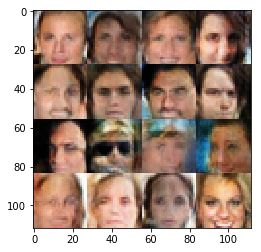

Epoch 1/1... Discriminator Loss: 1.0957... Generator Loss: 0.7322
Epoch 1/1... Discriminator Loss: 0.7526... Generator Loss: 0.9809
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.5413
Epoch 1/1... Discriminator Loss: 1.8615... Generator Loss: 0.2620
Epoch 1/1... Discriminator Loss: 1.1760... Generator Loss: 0.6400
Epoch 1/1... Discriminator Loss: 1.0636... Generator Loss: 0.8938
Epoch 1/1... Discriminator Loss: 1.6689... Generator Loss: 0.2900
Epoch 1/1... Discriminator Loss: 0.9579... Generator Loss: 0.8171
Epoch 1/1... Discriminator Loss: 1.5210... Generator Loss: 0.4433
Epoch 1/1... Discriminator Loss: 1.2903... Generator Loss: 0.5344


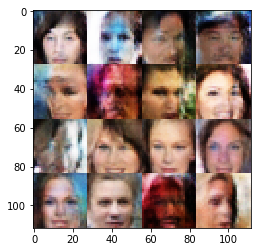

Epoch 1/1... Discriminator Loss: 1.2629... Generator Loss: 0.6046
Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 0.5588
Epoch 1/1... Discriminator Loss: 1.3527... Generator Loss: 0.4535
Epoch 1/1... Discriminator Loss: 1.6768... Generator Loss: 0.3073
Epoch 1/1... Discriminator Loss: 1.2445... Generator Loss: 0.4980
Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.6711
Epoch 1/1... Discriminator Loss: 1.1291... Generator Loss: 0.6026
Epoch 1/1... Discriminator Loss: 1.1109... Generator Loss: 0.5465
Epoch 1/1... Discriminator Loss: 1.1429... Generator Loss: 0.5876
Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 0.5870


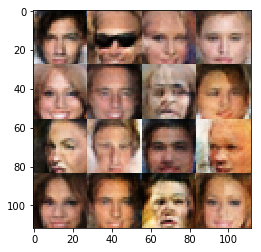

Epoch 1/1... Discriminator Loss: 1.3603... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 1.1082... Generator Loss: 0.8746
Epoch 1/1... Discriminator Loss: 1.2986... Generator Loss: 0.7521
Epoch 1/1... Discriminator Loss: 0.9666... Generator Loss: 0.8119
Epoch 1/1... Discriminator Loss: 1.2934... Generator Loss: 0.6756
Epoch 1/1... Discriminator Loss: 1.2779... Generator Loss: 0.5824
Epoch 1/1... Discriminator Loss: 1.0772... Generator Loss: 0.8402
Epoch 1/1... Discriminator Loss: 0.8536... Generator Loss: 0.8094
Epoch 1/1... Discriminator Loss: 1.0854... Generator Loss: 0.6624
Epoch 1/1... Discriminator Loss: 1.1102... Generator Loss: 0.6832


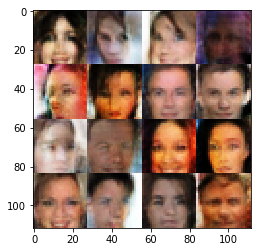

Epoch 1/1... Discriminator Loss: 1.1663... Generator Loss: 0.6189
Epoch 1/1... Discriminator Loss: 1.2996... Generator Loss: 0.6105
Epoch 1/1... Discriminator Loss: 1.2543... Generator Loss: 0.7397
Epoch 1/1... Discriminator Loss: 1.2408... Generator Loss: 0.5364
Epoch 1/1... Discriminator Loss: 1.1555... Generator Loss: 0.7703
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.5263
Epoch 1/1... Discriminator Loss: 1.5116... Generator Loss: 0.3859
Epoch 1/1... Discriminator Loss: 1.1142... Generator Loss: 0.6445
Epoch 1/1... Discriminator Loss: 1.3145... Generator Loss: 0.8246
Epoch 1/1... Discriminator Loss: 1.2778... Generator Loss: 0.5463


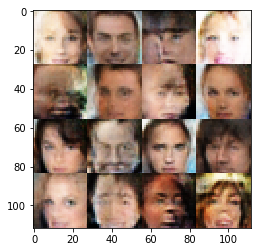

Epoch 1/1... Discriminator Loss: 1.1897... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 1.2876... Generator Loss: 0.5796
Epoch 1/1... Discriminator Loss: 1.6826... Generator Loss: 0.4174
Epoch 1/1... Discriminator Loss: 1.3420... Generator Loss: 0.4851
Epoch 1/1... Discriminator Loss: 1.2009... Generator Loss: 0.7314
Epoch 1/1... Discriminator Loss: 1.1195... Generator Loss: 0.6884
Epoch 1/1... Discriminator Loss: 1.2579... Generator Loss: 0.5167
Epoch 1/1... Discriminator Loss: 1.5216... Generator Loss: 0.5577
Epoch 1/1... Discriminator Loss: 1.2458... Generator Loss: 0.4773
Epoch 1/1... Discriminator Loss: 1.3260... Generator Loss: 0.5367


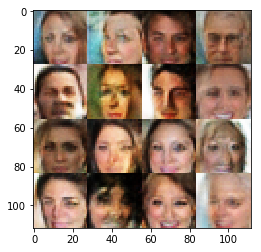

Epoch 1/1... Discriminator Loss: 0.9392... Generator Loss: 0.9821
Epoch 1/1... Discriminator Loss: 1.3353... Generator Loss: 0.5880
Epoch 1/1... Discriminator Loss: 0.9521... Generator Loss: 0.7938
Epoch 1/1... Discriminator Loss: 1.1277... Generator Loss: 0.5138
Epoch 1/1... Discriminator Loss: 1.2351... Generator Loss: 0.5918
Epoch 1/1... Discriminator Loss: 1.3486... Generator Loss: 0.5277
Epoch 1/1... Discriminator Loss: 1.5060... Generator Loss: 0.3439
Epoch 1/1... Discriminator Loss: 0.8239... Generator Loss: 0.9780
Epoch 1/1... Discriminator Loss: 1.4512... Generator Loss: 0.3511
Epoch 1/1... Discriminator Loss: 1.2320... Generator Loss: 0.4983


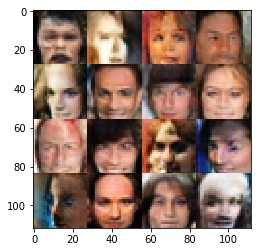

Epoch 1/1... Discriminator Loss: 1.1222... Generator Loss: 0.6047
Epoch 1/1... Discriminator Loss: 1.4420... Generator Loss: 0.4046
Epoch 1/1... Discriminator Loss: 1.2478... Generator Loss: 0.5805
Epoch 1/1... Discriminator Loss: 1.0708... Generator Loss: 0.6122
Epoch 1/1... Discriminator Loss: 1.8702... Generator Loss: 0.2612
Epoch 1/1... Discriminator Loss: 1.1279... Generator Loss: 0.7155
Epoch 1/1... Discriminator Loss: 1.4754... Generator Loss: 0.4623
Epoch 1/1... Discriminator Loss: 1.0981... Generator Loss: 0.8707
Epoch 1/1... Discriminator Loss: 1.0444... Generator Loss: 0.8719
Epoch 1/1... Discriminator Loss: 1.2362... Generator Loss: 0.6484


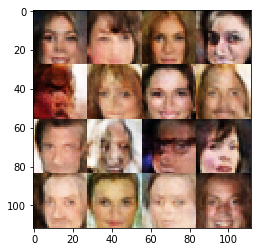

Epoch 1/1... Discriminator Loss: 0.6393... Generator Loss: 1.1890
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.4242
Epoch 1/1... Discriminator Loss: 1.1781... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 0.8886... Generator Loss: 1.1124
Epoch 1/1... Discriminator Loss: 1.2929... Generator Loss: 0.5488
Epoch 1/1... Discriminator Loss: 1.5388... Generator Loss: 0.4340
Epoch 1/1... Discriminator Loss: 1.1925... Generator Loss: 0.5489
Epoch 1/1... Discriminator Loss: 1.0650... Generator Loss: 0.5968
Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 0.7216
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.3954


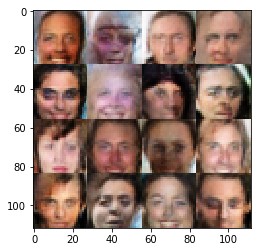

Epoch 1/1... Discriminator Loss: 1.3402... Generator Loss: 0.6216
Epoch 1/1... Discriminator Loss: 1.2207... Generator Loss: 0.7840
Epoch 1/1... Discriminator Loss: 1.1909... Generator Loss: 0.5469
Epoch 1/1... Discriminator Loss: 1.3136... Generator Loss: 0.5009
Epoch 1/1... Discriminator Loss: 1.3550... Generator Loss: 0.4245
Epoch 1/1... Discriminator Loss: 1.1557... Generator Loss: 0.6835
Epoch 1/1... Discriminator Loss: 1.1133... Generator Loss: 0.6978
Epoch 1/1... Discriminator Loss: 1.2773... Generator Loss: 0.4840
Epoch 1/1... Discriminator Loss: 1.9408... Generator Loss: 0.2185
Epoch 1/1... Discriminator Loss: 1.0083... Generator Loss: 0.7634


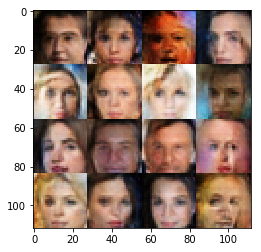

Epoch 1/1... Discriminator Loss: 1.2795... Generator Loss: 0.4781
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.4355
Epoch 1/1... Discriminator Loss: 1.1197... Generator Loss: 0.5750
Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.4764
Epoch 1/1... Discriminator Loss: 1.2245... Generator Loss: 0.5247
Epoch 1/1... Discriminator Loss: 1.2063... Generator Loss: 0.5373
Epoch 1/1... Discriminator Loss: 1.1883... Generator Loss: 0.5238
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 0.5582
Epoch 1/1... Discriminator Loss: 1.3155... Generator Loss: 1.1916
Epoch 1/1... Discriminator Loss: 1.2245... Generator Loss: 0.5699


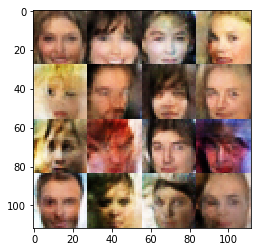

Epoch 1/1... Discriminator Loss: 1.2584... Generator Loss: 0.5303
Epoch 1/1... Discriminator Loss: 1.3008... Generator Loss: 0.6001
Epoch 1/1... Discriminator Loss: 0.9928... Generator Loss: 0.9484
Epoch 1/1... Discriminator Loss: 1.1603... Generator Loss: 0.5837
Epoch 1/1... Discriminator Loss: 1.2238... Generator Loss: 0.7737
Epoch 1/1... Discriminator Loss: 1.2752... Generator Loss: 0.5488
Epoch 1/1... Discriminator Loss: 0.9031... Generator Loss: 0.7777
Epoch 1/1... Discriminator Loss: 1.5267... Generator Loss: 0.3325
Epoch 1/1... Discriminator Loss: 1.0145... Generator Loss: 0.9222
Epoch 1/1... Discriminator Loss: 1.0740... Generator Loss: 0.8465


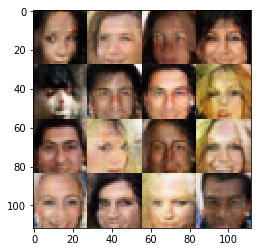

Epoch 1/1... Discriminator Loss: 1.4824... Generator Loss: 0.5730
Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.5160
Epoch 1/1... Discriminator Loss: 1.0130... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 0.9190... Generator Loss: 0.8587
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.4808
Epoch 1/1... Discriminator Loss: 0.8170... Generator Loss: 0.8276
Epoch 1/1... Discriminator Loss: 1.2458... Generator Loss: 0.5833
Epoch 1/1... Discriminator Loss: 1.5850... Generator Loss: 0.4193
Epoch 1/1... Discriminator Loss: 1.0892... Generator Loss: 0.6697
Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 0.4794


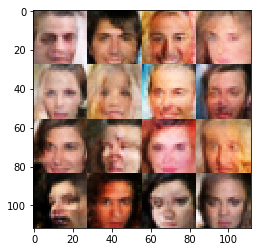

Epoch 1/1... Discriminator Loss: 1.0271... Generator Loss: 0.7604
Epoch 1/1... Discriminator Loss: 1.5271... Generator Loss: 0.4044
Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.4151
Epoch 1/1... Discriminator Loss: 1.1978... Generator Loss: 0.5511
Epoch 1/1... Discriminator Loss: 1.1459... Generator Loss: 0.7054
Epoch 1/1... Discriminator Loss: 0.9429... Generator Loss: 0.7324
Epoch 1/1... Discriminator Loss: 1.6293... Generator Loss: 0.3312
Epoch 1/1... Discriminator Loss: 1.1060... Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 1.0187... Generator Loss: 0.7040
Epoch 1/1... Discriminator Loss: 1.1270... Generator Loss: 0.6294


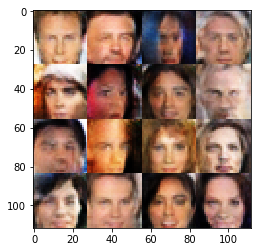

Epoch 1/1... Discriminator Loss: 1.0731... Generator Loss: 0.5871
Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 0.4198
Epoch 1/1... Discriminator Loss: 1.2541... Generator Loss: 0.4933
Epoch 1/1... Discriminator Loss: 1.0766... Generator Loss: 0.6022
Epoch 1/1... Discriminator Loss: 1.2423... Generator Loss: 1.0439
Epoch 1/1... Discriminator Loss: 1.0629... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 1.1087... Generator Loss: 0.5878
Epoch 1/1... Discriminator Loss: 0.7786... Generator Loss: 0.9939
Epoch 1/1... Discriminator Loss: 1.0670... Generator Loss: 0.6954
Epoch 1/1... Discriminator Loss: 1.2810... Generator Loss: 0.5415


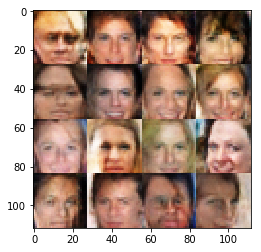

Epoch 1/1... Discriminator Loss: 1.5412... Generator Loss: 0.3217
Epoch 1/1... Discriminator Loss: 1.1822... Generator Loss: 0.7265
Epoch 1/1... Discriminator Loss: 1.7413... Generator Loss: 0.2373
Epoch 1/1... Discriminator Loss: 1.2587... Generator Loss: 0.4437
Epoch 1/1... Discriminator Loss: 1.3310... Generator Loss: 0.4536
Epoch 1/1... Discriminator Loss: 1.1583... Generator Loss: 0.5890
Epoch 1/1... Discriminator Loss: 0.8973... Generator Loss: 1.0296
Epoch 1/1... Discriminator Loss: 1.6266... Generator Loss: 0.2958
Epoch 1/1... Discriminator Loss: 1.2210... Generator Loss: 0.5204
Epoch 1/1... Discriminator Loss: 1.6933... Generator Loss: 0.3147


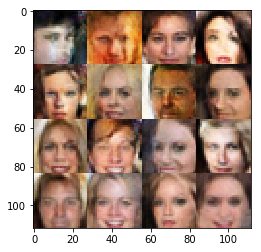

Epoch 1/1... Discriminator Loss: 1.5870... Generator Loss: 0.9899
Epoch 1/1... Discriminator Loss: 1.3126... Generator Loss: 0.4325
Epoch 1/1... Discriminator Loss: 1.2413... Generator Loss: 0.4344
Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 0.3791
Epoch 1/1... Discriminator Loss: 1.1312... Generator Loss: 0.6133
Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 0.4292
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.3670
Epoch 1/1... Discriminator Loss: 1.2286... Generator Loss: 0.6336
Epoch 1/1... Discriminator Loss: 0.8299... Generator Loss: 1.1765
Epoch 1/1... Discriminator Loss: 1.3153... Generator Loss: 0.7567


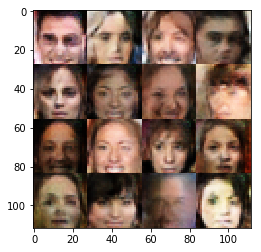

Epoch 1/1... Discriminator Loss: 1.5597... Generator Loss: 0.4127
Epoch 1/1... Discriminator Loss: 0.8936... Generator Loss: 0.7824
Epoch 1/1... Discriminator Loss: 1.4880... Generator Loss: 0.3571
Epoch 1/1... Discriminator Loss: 1.3062... Generator Loss: 0.4564
Epoch 1/1... Discriminator Loss: 1.1582... Generator Loss: 0.4722
Epoch 1/1... Discriminator Loss: 1.0824... Generator Loss: 0.9846
Epoch 1/1... Discriminator Loss: 0.9939... Generator Loss: 0.8260
Epoch 1/1... Discriminator Loss: 1.0957... Generator Loss: 0.8692
Epoch 1/1... Discriminator Loss: 1.5990... Generator Loss: 0.4743
Epoch 1/1... Discriminator Loss: 1.1604... Generator Loss: 0.4808


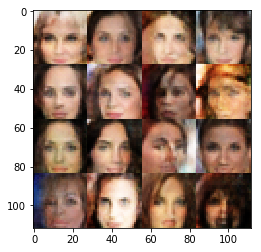

Epoch 1/1... Discriminator Loss: 1.1044... Generator Loss: 0.7719
Epoch 1/1... Discriminator Loss: 1.3151... Generator Loss: 0.6970
Epoch 1/1... Discriminator Loss: 0.8804... Generator Loss: 0.7950
Epoch 1/1... Discriminator Loss: 0.7675... Generator Loss: 0.8966
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.4984
Epoch 1/1... Discriminator Loss: 1.0484... Generator Loss: 0.5957
Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.5170
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.4392
Epoch 1/1... Discriminator Loss: 1.2052... Generator Loss: 0.4552
Epoch 1/1... Discriminator Loss: 1.1485... Generator Loss: 0.5274


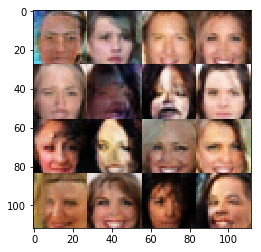

Epoch 1/1... Discriminator Loss: 0.8592... Generator Loss: 0.8604
Epoch 1/1... Discriminator Loss: 1.1247... Generator Loss: 0.8862
Epoch 1/1... Discriminator Loss: 1.4365... Generator Loss: 0.4136
Epoch 1/1... Discriminator Loss: 1.6382... Generator Loss: 0.2728
Epoch 1/1... Discriminator Loss: 0.7243... Generator Loss: 1.1573
Epoch 1/1... Discriminator Loss: 0.8414... Generator Loss: 0.8478
Epoch 1/1... Discriminator Loss: 1.1471... Generator Loss: 0.5225
Epoch 1/1... Discriminator Loss: 0.7849... Generator Loss: 0.8731
Epoch 1/1... Discriminator Loss: 1.1715... Generator Loss: 0.4335
Epoch 1/1... Discriminator Loss: 1.2586... Generator Loss: 0.7349


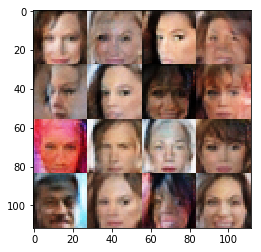

Epoch 1/1... Discriminator Loss: 1.0487... Generator Loss: 0.6350
Epoch 1/1... Discriminator Loss: 0.9306... Generator Loss: 0.7928
Epoch 1/1... Discriminator Loss: 0.6670... Generator Loss: 1.5517
Epoch 1/1... Discriminator Loss: 1.2145... Generator Loss: 0.6569
Epoch 1/1... Discriminator Loss: 0.8576... Generator Loss: 0.8204
Epoch 1/1... Discriminator Loss: 1.6162... Generator Loss: 0.2822
Epoch 1/1... Discriminator Loss: 1.0317... Generator Loss: 0.5586
Epoch 1/1... Discriminator Loss: 1.2503... Generator Loss: 0.4714
Epoch 1/1... Discriminator Loss: 0.5071... Generator Loss: 1.2881
Epoch 1/1... Discriminator Loss: 1.2267... Generator Loss: 0.5613


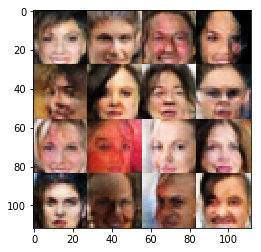

Epoch 1/1... Discriminator Loss: 0.8892... Generator Loss: 1.0072
Epoch 1/1... Discriminator Loss: 1.3000... Generator Loss: 0.3790
Epoch 1/1... Discriminator Loss: 1.4950... Generator Loss: 0.3479
Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.5840
Epoch 1/1... Discriminator Loss: 1.1210... Generator Loss: 0.4932
Epoch 1/1... Discriminator Loss: 2.1267... Generator Loss: 0.1705
Epoch 1/1... Discriminator Loss: 0.8794... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 1.1499... Generator Loss: 1.0837
Epoch 1/1... Discriminator Loss: 1.9018... Generator Loss: 0.1996
Epoch 1/1... Discriminator Loss: 1.0327... Generator Loss: 0.9607


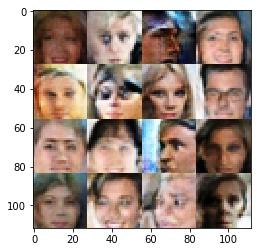

Epoch 1/1... Discriminator Loss: 1.1284... Generator Loss: 0.6177
Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 0.4071
Epoch 1/1... Discriminator Loss: 1.3070... Generator Loss: 0.4559
Epoch 1/1... Discriminator Loss: 1.6054... Generator Loss: 0.3529
Epoch 1/1... Discriminator Loss: 0.8754... Generator Loss: 1.7323
Epoch 1/1... Discriminator Loss: 1.2744... Generator Loss: 0.8009
Epoch 1/1... Discriminator Loss: 1.0246... Generator Loss: 0.5958
Epoch 1/1... Discriminator Loss: 1.5782... Generator Loss: 0.2743
Epoch 1/1... Discriminator Loss: 1.1364... Generator Loss: 0.5799
Epoch 1/1... Discriminator Loss: 0.9762... Generator Loss: 0.6442


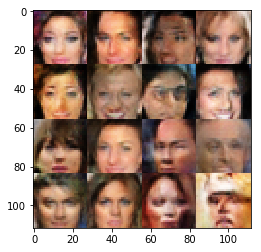

Epoch 1/1... Discriminator Loss: 1.4897... Generator Loss: 0.6498
Epoch 1/1... Discriminator Loss: 1.0880... Generator Loss: 0.7962
Epoch 1/1... Discriminator Loss: 1.0055... Generator Loss: 0.7128
Epoch 1/1... Discriminator Loss: 0.9787... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 1.6095... Generator Loss: 0.3340
Epoch 1/1... Discriminator Loss: 1.0622... Generator Loss: 0.6069
Epoch 1/1... Discriminator Loss: 1.0992... Generator Loss: 0.5872
Epoch 1/1... Discriminator Loss: 1.0786... Generator Loss: 0.5993
Epoch 1/1... Discriminator Loss: 1.2881... Generator Loss: 0.4512
Epoch 1/1... Discriminator Loss: 0.8672... Generator Loss: 0.7068


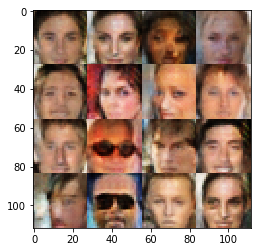

Epoch 1/1... Discriminator Loss: 1.0437... Generator Loss: 0.6225
Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 0.3770
Epoch 1/1... Discriminator Loss: 1.8132... Generator Loss: 0.2433
Epoch 1/1... Discriminator Loss: 1.2718... Generator Loss: 0.5036
Epoch 1/1... Discriminator Loss: 1.1643... Generator Loss: 0.5200
Epoch 1/1... Discriminator Loss: 1.4255... Generator Loss: 0.4323
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 1.3300
Epoch 1/1... Discriminator Loss: 0.9494... Generator Loss: 0.6864
Epoch 1/1... Discriminator Loss: 0.9560... Generator Loss: 0.7513
Epoch 1/1... Discriminator Loss: 1.2004... Generator Loss: 0.5910


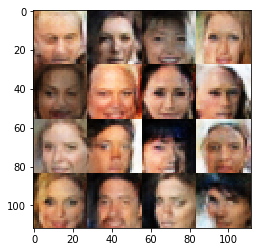

Epoch 1/1... Discriminator Loss: 0.8472... Generator Loss: 0.6684
Epoch 1/1... Discriminator Loss: 1.0343... Generator Loss: 0.7232
Epoch 1/1... Discriminator Loss: 1.4892... Generator Loss: 0.3289
Epoch 1/1... Discriminator Loss: 1.1319... Generator Loss: 0.6432
Epoch 1/1... Discriminator Loss: 0.6757... Generator Loss: 1.5286
Epoch 1/1... Discriminator Loss: 1.6305... Generator Loss: 0.4115
Epoch 1/1... Discriminator Loss: 1.2011... Generator Loss: 0.7741
Epoch 1/1... Discriminator Loss: 0.7929... Generator Loss: 1.3887
Epoch 1/1... Discriminator Loss: 0.8497... Generator Loss: 0.9587
Epoch 1/1... Discriminator Loss: 1.7526... Generator Loss: 0.2583


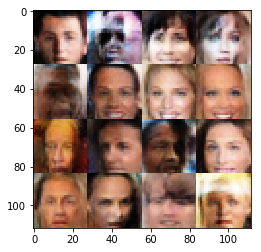

Epoch 1/1... Discriminator Loss: 1.0368... Generator Loss: 0.5860
Epoch 1/1... Discriminator Loss: 1.5793... Generator Loss: 0.2945
Epoch 1/1... Discriminator Loss: 1.5207... Generator Loss: 1.2640
Epoch 1/1... Discriminator Loss: 1.6957... Generator Loss: 0.2596
Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.5609
Epoch 1/1... Discriminator Loss: 1.3175... Generator Loss: 0.4625
Epoch 1/1... Discriminator Loss: 0.6443... Generator Loss: 1.2490
Epoch 1/1... Discriminator Loss: 1.7738... Generator Loss: 0.2450
Epoch 1/1... Discriminator Loss: 1.7090... Generator Loss: 0.3751
Epoch 1/1... Discriminator Loss: 2.2781... Generator Loss: 0.1232


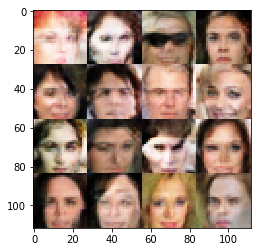

Epoch 1/1... Discriminator Loss: 1.2201... Generator Loss: 0.4494
Epoch 1/1... Discriminator Loss: 0.5725... Generator Loss: 1.8628
Epoch 1/1... Discriminator Loss: 0.7162... Generator Loss: 1.8387
Epoch 1/1... Discriminator Loss: 1.2278... Generator Loss: 0.4600
Epoch 1/1... Discriminator Loss: 1.1801... Generator Loss: 0.5727
Epoch 1/1... Discriminator Loss: 1.1189... Generator Loss: 0.5311
Epoch 1/1... Discriminator Loss: 0.9722... Generator Loss: 1.0087
Epoch 1/1... Discriminator Loss: 1.5012... Generator Loss: 0.3745
Epoch 1/1... Discriminator Loss: 0.9193... Generator Loss: 1.0188
Epoch 1/1... Discriminator Loss: 1.1309... Generator Loss: 0.6437


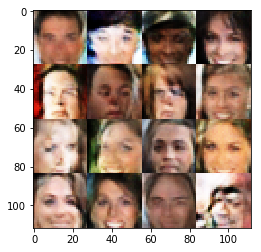

Epoch 1/1... Discriminator Loss: 1.1417... Generator Loss: 0.6121
Epoch 1/1... Discriminator Loss: 0.7719... Generator Loss: 0.9496
Epoch 1/1... Discriminator Loss: 0.6264... Generator Loss: 1.4148
Epoch 1/1... Discriminator Loss: 1.0386... Generator Loss: 0.7210
Epoch 1/1... Discriminator Loss: 0.6387... Generator Loss: 1.0136
Epoch 1/1... Discriminator Loss: 0.9925... Generator Loss: 0.8956
Epoch 1/1... Discriminator Loss: 1.2064... Generator Loss: 0.5074
Epoch 1/1... Discriminator Loss: 0.6567... Generator Loss: 1.1121
Epoch 1/1... Discriminator Loss: 1.1780... Generator Loss: 1.3072
Epoch 1/1... Discriminator Loss: 0.5685... Generator Loss: 1.1559


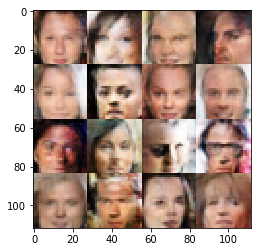

Epoch 1/1... Discriminator Loss: 0.6032... Generator Loss: 1.0180
Epoch 1/1... Discriminator Loss: 2.1380... Generator Loss: 2.1152
Epoch 1/1... Discriminator Loss: 1.1007... Generator Loss: 0.5563
Epoch 1/1... Discriminator Loss: 1.4572... Generator Loss: 0.3555
Epoch 1/1... Discriminator Loss: 0.5090... Generator Loss: 1.7521
Epoch 1/1... Discriminator Loss: 0.9749... Generator Loss: 1.2439
Epoch 1/1... Discriminator Loss: 0.7192... Generator Loss: 0.8747
Epoch 1/1... Discriminator Loss: 1.2273... Generator Loss: 0.4883
Epoch 1/1... Discriminator Loss: 0.9067... Generator Loss: 0.7544
Epoch 1/1... Discriminator Loss: 1.0481... Generator Loss: 0.5932


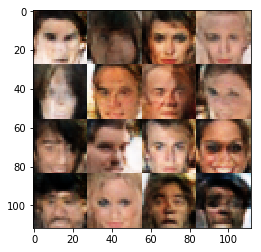

Epoch 1/1... Discriminator Loss: 0.6949... Generator Loss: 0.9846
Epoch 1/1... Discriminator Loss: 1.1190... Generator Loss: 0.5632
Epoch 1/1... Discriminator Loss: 1.1487... Generator Loss: 0.5242
Epoch 1/1... Discriminator Loss: 1.2460... Generator Loss: 0.4882
Epoch 1/1... Discriminator Loss: 0.5146... Generator Loss: 2.0162
Epoch 1/1... Discriminator Loss: 1.4916... Generator Loss: 0.3658
Epoch 1/1... Discriminator Loss: 0.6154... Generator Loss: 1.6468
Epoch 1/1... Discriminator Loss: 1.7388... Generator Loss: 0.2501
Epoch 1/1... Discriminator Loss: 0.4943... Generator Loss: 1.9921
Epoch 1/1... Discriminator Loss: 0.6698... Generator Loss: 1.5307


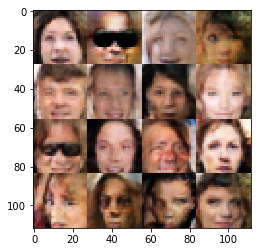

Epoch 1/1... Discriminator Loss: 0.9085... Generator Loss: 1.2037
Epoch 1/1... Discriminator Loss: 1.0179... Generator Loss: 0.7639
Epoch 1/1... Discriminator Loss: 1.1332... Generator Loss: 0.9195
Epoch 1/1... Discriminator Loss: 0.6587... Generator Loss: 0.9489
Epoch 1/1... Discriminator Loss: 0.8677... Generator Loss: 1.5963
Epoch 1/1... Discriminator Loss: 0.8592... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 0.7916... Generator Loss: 0.8494
Epoch 1/1... Discriminator Loss: 0.7922... Generator Loss: 0.8207
Epoch 1/1... Discriminator Loss: 1.8913... Generator Loss: 0.2508
Epoch 1/1... Discriminator Loss: 0.8977... Generator Loss: 0.7322


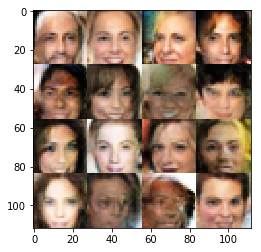

Epoch 1/1... Discriminator Loss: 1.0986... Generator Loss: 0.5874
Epoch 1/1... Discriminator Loss: 1.2655... Generator Loss: 0.4620
Epoch 1/1... Discriminator Loss: 0.7151... Generator Loss: 0.9176
Epoch 1/1... Discriminator Loss: 0.4937... Generator Loss: 1.1580
Epoch 1/1... Discriminator Loss: 0.7476... Generator Loss: 1.0199
Epoch 1/1... Discriminator Loss: 1.4544... Generator Loss: 0.3591
Epoch 1/1... Discriminator Loss: 0.9526... Generator Loss: 0.6257
Epoch 1/1... Discriminator Loss: 0.6156... Generator Loss: 2.6227
Epoch 1/1... Discriminator Loss: 0.4570... Generator Loss: 1.8460
Epoch 1/1... Discriminator Loss: 0.8372... Generator Loss: 1.5342


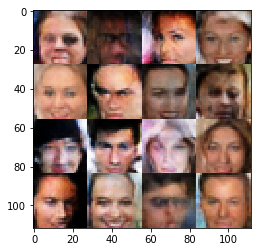

Epoch 1/1... Discriminator Loss: 1.2105... Generator Loss: 0.5784
Epoch 1/1... Discriminator Loss: 0.2261... Generator Loss: 2.5987
Epoch 1/1... Discriminator Loss: 1.4317... Generator Loss: 0.5097
Epoch 1/1... Discriminator Loss: 1.5033... Generator Loss: 0.3549
Epoch 1/1... Discriminator Loss: 1.0767... Generator Loss: 0.6780
Epoch 1/1... Discriminator Loss: 0.9838... Generator Loss: 0.9270
Epoch 1/1... Discriminator Loss: 1.2253... Generator Loss: 0.4689
Epoch 1/1... Discriminator Loss: 0.8963... Generator Loss: 0.7626
Epoch 1/1... Discriminator Loss: 0.7613... Generator Loss: 0.8997
Epoch 1/1... Discriminator Loss: 0.3222... Generator Loss: 1.7327


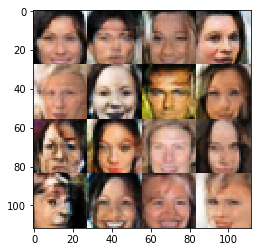

Epoch 1/1... Discriminator Loss: 0.7965... Generator Loss: 1.7350
Epoch 1/1... Discriminator Loss: 0.4275... Generator Loss: 2.5248
Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.4809
Epoch 1/1... Discriminator Loss: 0.8862... Generator Loss: 0.7567
Epoch 1/1... Discriminator Loss: 1.1611... Generator Loss: 1.3235
Epoch 1/1... Discriminator Loss: 0.8779... Generator Loss: 0.7269
Epoch 1/1... Discriminator Loss: 0.5570... Generator Loss: 1.2572
Epoch 1/1... Discriminator Loss: 0.7328... Generator Loss: 1.3857
Epoch 1/1... Discriminator Loss: 0.5055... Generator Loss: 1.4300
Epoch 1/1... Discriminator Loss: 0.4887... Generator Loss: 2.1993


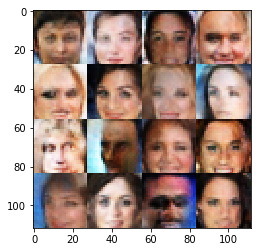

Epoch 1/1... Discriminator Loss: 0.7511... Generator Loss: 0.8349
Epoch 1/1... Discriminator Loss: 1.0473... Generator Loss: 0.6933
Epoch 1/1... Discriminator Loss: 2.1818... Generator Loss: 0.1498
Epoch 1/1... Discriminator Loss: 0.8503... Generator Loss: 0.8447
Epoch 1/1... Discriminator Loss: 1.2291... Generator Loss: 1.1634
Epoch 1/1... Discriminator Loss: 1.0402... Generator Loss: 0.5745
Epoch 1/1... Discriminator Loss: 1.0417... Generator Loss: 0.6751
Epoch 1/1... Discriminator Loss: 1.8260... Generator Loss: 2.3842
Epoch 1/1... Discriminator Loss: 1.1336... Generator Loss: 0.5113
Epoch 1/1... Discriminator Loss: 0.9849... Generator Loss: 0.8726


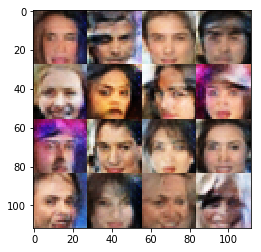

Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.3589
Epoch 1/1... Discriminator Loss: 0.6169... Generator Loss: 0.9968
Epoch 1/1... Discriminator Loss: 0.5143... Generator Loss: 1.3296
Epoch 1/1... Discriminator Loss: 1.5050... Generator Loss: 0.4913
Epoch 1/1... Discriminator Loss: 1.1432... Generator Loss: 0.6612
Epoch 1/1... Discriminator Loss: 1.9213... Generator Loss: 0.2272
Epoch 1/1... Discriminator Loss: 1.0390... Generator Loss: 0.9619
Epoch 1/1... Discriminator Loss: 1.1265... Generator Loss: 0.6591
Epoch 1/1... Discriminator Loss: 1.8858... Generator Loss: 0.3603
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.5317


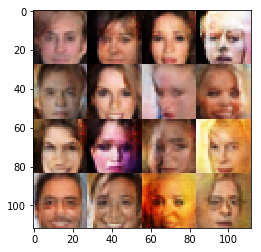

Epoch 1/1... Discriminator Loss: 1.3430... Generator Loss: 0.4886
Epoch 1/1... Discriminator Loss: 1.1285... Generator Loss: 0.6773
Epoch 1/1... Discriminator Loss: 1.0084... Generator Loss: 0.8069
Epoch 1/1... Discriminator Loss: 1.2323... Generator Loss: 0.5275
Epoch 1/1... Discriminator Loss: 1.1881... Generator Loss: 0.6669
Epoch 1/1... Discriminator Loss: 1.0655... Generator Loss: 0.7439
Epoch 1/1... Discriminator Loss: 0.8281... Generator Loss: 1.0162
Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 0.4078
Epoch 1/1... Discriminator Loss: 0.8875... Generator Loss: 0.6844
Epoch 1/1... Discriminator Loss: 0.8216... Generator Loss: 0.6464


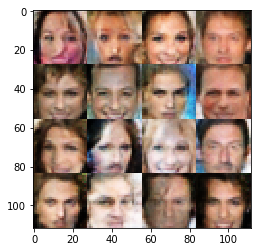

Epoch 1/1... Discriminator Loss: 0.4903... Generator Loss: 1.2418
Epoch 1/1... Discriminator Loss: 1.4726... Generator Loss: 0.4314
Epoch 1/1... Discriminator Loss: 0.9477... Generator Loss: 0.7663
Epoch 1/1... Discriminator Loss: 1.0258... Generator Loss: 0.7138
Epoch 1/1... Discriminator Loss: 1.1413... Generator Loss: 0.6960
Epoch 1/1... Discriminator Loss: 1.2459... Generator Loss: 0.5413
Epoch 1/1... Discriminator Loss: 0.8525... Generator Loss: 1.0613
Epoch 1/1... Discriminator Loss: 1.2670... Generator Loss: 0.5887
Epoch 1/1... Discriminator Loss: 1.1583... Generator Loss: 1.3664
Epoch 1/1... Discriminator Loss: 0.5486... Generator Loss: 2.1160


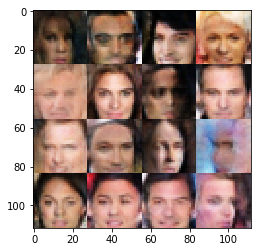

Epoch 1/1... Discriminator Loss: 1.1714... Generator Loss: 0.7421
Epoch 1/1... Discriminator Loss: 1.1633... Generator Loss: 0.5702
Epoch 1/1... Discriminator Loss: 0.7815... Generator Loss: 0.9044
Epoch 1/1... Discriminator Loss: 0.5227... Generator Loss: 2.3509
Epoch 1/1... Discriminator Loss: 0.5599... Generator Loss: 1.2540
Epoch 1/1... Discriminator Loss: 1.8260... Generator Loss: 0.2162
Epoch 1/1... Discriminator Loss: 1.1457... Generator Loss: 0.4906
Epoch 1/1... Discriminator Loss: 1.3317... Generator Loss: 0.4433
Epoch 1/1... Discriminator Loss: 1.1560... Generator Loss: 0.9807
Epoch 1/1... Discriminator Loss: 0.4289... Generator Loss: 1.4305


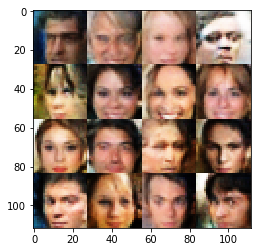

Epoch 1/1... Discriminator Loss: 0.5013... Generator Loss: 1.2698
Epoch 1/1... Discriminator Loss: 0.9638... Generator Loss: 0.6544
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.3755
Epoch 1/1... Discriminator Loss: 2.7590... Generator Loss: 1.4839
Epoch 1/1... Discriminator Loss: 1.1192... Generator Loss: 0.5259
Epoch 1/1... Discriminator Loss: 1.2727... Generator Loss: 0.4218
Epoch 1/1... Discriminator Loss: 0.9981... Generator Loss: 0.6505
Epoch 1/1... Discriminator Loss: 0.6321... Generator Loss: 1.1194
Epoch 1/1... Discriminator Loss: 1.1877... Generator Loss: 0.4912
Epoch 1/1... Discriminator Loss: 0.6422... Generator Loss: 1.1985


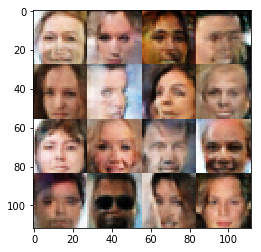

Epoch 1/1... Discriminator Loss: 1.7548... Generator Loss: 0.2126
Epoch 1/1... Discriminator Loss: 1.0690... Generator Loss: 1.0645
Epoch 1/1... Discriminator Loss: 0.7654... Generator Loss: 0.8531
Epoch 1/1... Discriminator Loss: 2.3611... Generator Loss: 0.1317
Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.4110
Epoch 1/1... Discriminator Loss: 0.8553... Generator Loss: 0.8330
Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 0.4790
Epoch 1/1... Discriminator Loss: 0.3967... Generator Loss: 1.6062
Epoch 1/1... Discriminator Loss: 0.7351... Generator Loss: 0.8323
Epoch 1/1... Discriminator Loss: 0.4412... Generator Loss: 3.1287


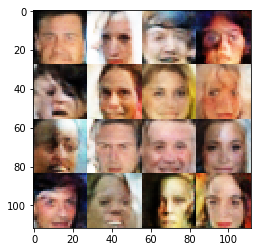

Epoch 1/1... Discriminator Loss: 0.8621... Generator Loss: 1.0102
Epoch 1/1... Discriminator Loss: 1.1684... Generator Loss: 0.4979
Epoch 1/1... Discriminator Loss: 1.6544... Generator Loss: 0.2572
Epoch 1/1... Discriminator Loss: 1.2392... Generator Loss: 0.4238
Epoch 1/1... Discriminator Loss: 1.0514... Generator Loss: 1.5236
Epoch 1/1... Discriminator Loss: 0.6211... Generator Loss: 1.0444
Epoch 1/1... Discriminator Loss: 0.9296... Generator Loss: 1.6606
Epoch 1/1... Discriminator Loss: 1.1758... Generator Loss: 0.5053
Epoch 1/1... Discriminator Loss: 0.8733... Generator Loss: 0.7715
Epoch 1/1... Discriminator Loss: 0.3322... Generator Loss: 1.9979


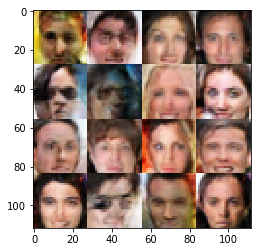

Epoch 1/1... Discriminator Loss: 1.0943... Generator Loss: 0.5326
Epoch 1/1... Discriminator Loss: 1.0651... Generator Loss: 0.6589
Epoch 1/1... Discriminator Loss: 1.6487... Generator Loss: 0.7894
Epoch 1/1... Discriminator Loss: 0.7604... Generator Loss: 1.2267
Epoch 1/1... Discriminator Loss: 1.0425... Generator Loss: 0.5374
Epoch 1/1... Discriminator Loss: 0.3349... Generator Loss: 1.6674
Epoch 1/1... Discriminator Loss: 1.7325... Generator Loss: 0.3038
Epoch 1/1... Discriminator Loss: 0.9539... Generator Loss: 0.6289
Epoch 1/1... Discriminator Loss: 0.5982... Generator Loss: 1.0511
Epoch 1/1... Discriminator Loss: 0.3807... Generator Loss: 1.7603


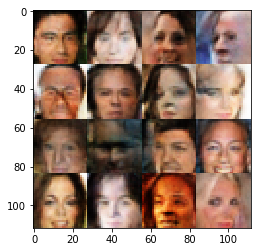

Epoch 1/1... Discriminator Loss: 1.5768... Generator Loss: 0.2749
Epoch 1/1... Discriminator Loss: 0.6339... Generator Loss: 1.0216
Epoch 1/1... Discriminator Loss: 1.5824... Generator Loss: 0.2978
Epoch 1/1... Discriminator Loss: 1.3119... Generator Loss: 0.3646
Epoch 1/1... Discriminator Loss: 0.9474... Generator Loss: 0.5783
Epoch 1/1... Discriminator Loss: 1.1959... Generator Loss: 0.4572
Epoch 1/1... Discriminator Loss: 0.5543... Generator Loss: 1.2573
Epoch 1/1... Discriminator Loss: 0.7608... Generator Loss: 0.9224
Epoch 1/1... Discriminator Loss: 1.0185... Generator Loss: 0.8606
Epoch 1/1... Discriminator Loss: 0.7079... Generator Loss: 1.4139


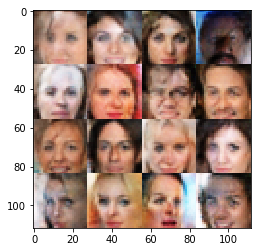

Epoch 1/1... Discriminator Loss: 0.6190... Generator Loss: 1.1447
Epoch 1/1... Discriminator Loss: 0.6702... Generator Loss: 0.9928
Epoch 1/1... Discriminator Loss: 0.9602... Generator Loss: 1.7107
Epoch 1/1... Discriminator Loss: 0.3323... Generator Loss: 1.6389
Epoch 1/1... Discriminator Loss: 1.2283... Generator Loss: 0.4601
Epoch 1/1... Discriminator Loss: 1.0974... Generator Loss: 0.5273


In [15]:
batch_size = 16
z_dim = 100
learning_rate = 0.0003
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。